In [3]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, ttest_ind, gaussian_kde, norm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from IPython.display import FileLink
from linearmodels.iv import IV2SLS

In [4]:
# Read the .sas7bdat file
file_path = "/Users/salmahoumane/Downloads/rr_rdd_data.sas7bdat"
df = pd.read_sas(file_path, format='sas7bdat', encoding='utf-8')

# Display the first few rows
print(df.head())

    SCHYR  SchoolID  StudentID  i3 StudyGroup  FTRL  FOWT   FLI   FWV  FHRSW  \
0  2012.0   10050.0   931018.0  i3         RR   0.0   5.0  45.0  14.0   18.0   
1  2012.0   10050.0   937570.0  i3         RR   0.0   9.0  46.0  19.0   19.0   
2  2012.0   10050.0   912947.0  i3         RR   0.0   5.0  50.0   1.0    8.0   
3  2012.0   10857.0   906051.0  i3         RR   1.0   0.0  48.0   6.0   10.0   
4  2012.0   10857.0   937290.0  i3         RR   0.0   0.0  26.0   4.0    3.0   

   ...  NumIntvn2  NumIntvn3  NumIntvn4  GotIntvn23  GotIntvn234  HasOS  \
0  ...        NaN        NaN        NaN         NaN          NaN    1.0   
1  ...        NaN        NaN        NaN         NaN          NaN    1.0   
2  ...        NaN        NaN        NaN         NaN          NaN    0.0   
3  ...        1.0        0.0        0.0         1.0          1.0    1.0   
4  ...        1.0        0.0        0.0         1.0          1.0    1.0   

   Has_BegYear_Scores  Has_MidYear_Scores  HasG3ST  HasG4ST  
0     

In [5]:
print(df.columns)

Index(['SCHYR', 'SchoolID', 'StudentID', 'i3', 'StudyGroup', 'FTRL', 'FOWT',
       'FLI', 'FWV', 'FHRSW', 'FCAP', 'FallTotalScore', 'MTRL', 'MOWT', 'MLI',
       'MWV', 'MHRSW', 'MCAP', 'MidYearTotalScore', 'GotRRfirst',
       'GotRRsecond', 'Fall_OSscore_Cntrd', 'Fall_BelowCut', 'c_Fall',
       'nRR_Fall', 'nTNI_Fall', 'MidYr_OSscore_Cntrd', 'MidYr_BelowCut',
       'c_MidYr', 'nRR_MidYr', 'nTNI_MidYr', 'G3_zscore', 'G4_zscore',
       'NumIntvn2', 'NumIntvn3', 'NumIntvn4', 'GotIntvn23', 'GotIntvn234',
       'HasOS', 'Has_BegYear_Scores', 'Has_MidYear_Scores', 'HasG3ST',
       'HasG4ST'],
      dtype='object')


In [6]:
# Drop rows with missing critical identifiers (e.g., SchoolID, StudentID)
df_clean = df.dropna(subset=["SchoolID", "StudentID"])

In [7]:
# Verify the cleaning process
print(f"Initial dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_clean)}")
print(f"Remaining schools: {df_clean['SchoolID'].nunique()}")
print(f"Columns in df_clean: {df_clean.columns}")

Initial dataset size: 38691
Cleaned dataset size: 38682
Remaining schools: 2034
Columns in df_clean: Index(['SCHYR', 'SchoolID', 'StudentID', 'i3', 'StudyGroup', 'FTRL', 'FOWT',
       'FLI', 'FWV', 'FHRSW', 'FCAP', 'FallTotalScore', 'MTRL', 'MOWT', 'MLI',
       'MWV', 'MHRSW', 'MCAP', 'MidYearTotalScore', 'GotRRfirst',
       'GotRRsecond', 'Fall_OSscore_Cntrd', 'Fall_BelowCut', 'c_Fall',
       'nRR_Fall', 'nTNI_Fall', 'MidYr_OSscore_Cntrd', 'MidYr_BelowCut',
       'c_MidYr', 'nRR_MidYr', 'nTNI_MidYr', 'G3_zscore', 'G4_zscore',
       'NumIntvn2', 'NumIntvn3', 'NumIntvn4', 'GotIntvn23', 'GotIntvn234',
       'HasOS', 'Has_BegYear_Scores', 'Has_MidYear_Scores', 'HasG3ST',
       'HasG4ST'],
      dtype='object')


## Attrition Analysis

Some schools were excluded from long-term data collection due to insufficient sample sizes within schools (i.e., fewer than seven students participating in Reading Recovery, or fewer than three comparison group students), and some students were excluded due to missing pre-intervention scores

### Student level attrition

In [8]:
# Function to calculate attrition statistics
def calculate_attrition_stats(df, grade_col, score_cols, group_col):
    results = []
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]

        # Students with test scores
        has_scores = group_data[group_data[grade_col] == 1]
        has_mean = has_scores[score_cols].mean()
        has_std = has_scores[score_cols].std()
        has_count = has_scores[score_cols].count()

        # Students without test scores
        missing_scores = group_data[group_data[grade_col] == 0]
        missing_mean = missing_scores[score_cols].mean()
        missing_std = missing_scores[score_cols].std()
        missing_count = missing_scores[score_cols].count()

        # Attrition rate
        total_count = len(group_data)
        attrition_rate = len(missing_scores) / total_count * 100 if total_count > 0 else 0

        # Append results
        results.append({
            "Group": group,
            "Grade": grade_col,
            "Has Scores - Mean (FallTotalScore)": has_mean["FallTotalScore"],
            "Has Scores - Std (FallTotalScore)": has_std["FallTotalScore"],
            "Has Scores - N (FallTotalScore)": has_count["FallTotalScore"],
            "Has Scores - Mean (MidYearTotalScore)": has_mean["MidYearTotalScore"],
            "Has Scores - Std (MidYearTotalScore)": has_std["MidYearTotalScore"],
            "Has Scores - N (MidYearTotalScore)": has_count["MidYearTotalScore"],
            "Missing Scores - Mean (FallTotalScore)": missing_mean["FallTotalScore"],
            "Missing Scores - Std (FallTotalScore)": missing_std["FallTotalScore"],
            "Missing Scores - N (FallTotalScore)": missing_count["FallTotalScore"],
            "Missing Scores - Mean (MidYearTotalScore)": missing_mean["MidYearTotalScore"],
            "Missing Scores - Std (MidYearTotalScore)": missing_std["MidYearTotalScore"],
            "Missing Scores - N (MidYearTotalScore)": missing_count["MidYearTotalScore"],
            "Attrition Rate (%)": attrition_rate,
        })

    return pd.DataFrame(results)

# Analyze attrition for 3rd-grade test scores
score_cols = ["FallTotalScore", "MidYearTotalScore"]
g3_stats = calculate_attrition_stats(df_clean, "HasG3ST", score_cols, "StudyGroup")

# Analyze attrition for 4th-grade test scores
g4_stats = calculate_attrition_stats(df_clean, "HasG4ST", score_cols, "StudyGroup")

# Perform chi-square tests for differential attrition
# Between groups for HasG3ST
chi2_g3, p_g3, _, _ = chi2_contingency(
    pd.crosstab(df_clean["StudyGroup"], df_clean["HasG3ST"])
)

# Between groups for HasG4ST
chi2_g4, p_g4, _, _ = chi2_contingency(
    pd.crosstab(df_clean["StudyGroup"], df_clean["HasG4ST"])
)

In [9]:
def format_attrition_table_with_missing(g3_stats, p_g3):
    # Create formatted DataFrame for Table 1
    table_with_missing = pd.DataFrame({
        "": [
            "Fall OS score Mean",
            "Fall OS score SD",
            "Fall OS score N",
            "Percent attrition",
            "Mid-year OS score Mean",
            "Mid-year OS score SD",
            "Mid-year OS score N",
            "Percent attrition",
        ],
        "Treatment group Has 3rd grade test scores": [
            g3_stats.loc[g3_stats["Group"] == "RR", "Has Scores - Mean (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Has Scores - Std (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Has Scores - N (FallTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
            g3_stats.loc[g3_stats["Group"] == "RR", "Has Scores - Mean (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Has Scores - Std (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Has Scores - N (MidYearTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
        ],
        "Treatment group Missing 3rd grade test scores": [
            g3_stats.loc[g3_stats["Group"] == "RR", "Missing Scores - Mean (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Missing Scores - Std (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Missing Scores - N (FallTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
            g3_stats.loc[g3_stats["Group"] == "RR", "Missing Scores - Mean (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Missing Scores - Std (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "RR", "Missing Scores - N (MidYearTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
        ],
        "Control group Has 3rd grade test scores": [
            g3_stats.loc[g3_stats["Group"] == "TNI", "Has Scores - Mean (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Has Scores - Std (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Has Scores - N (FallTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == 'TNI', 'Attrition Rate (%)'].values[0]:.2f}%",
            g3_stats.loc[g3_stats["Group"] == "TNI", "Has Scores - Mean (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Has Scores - Std (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Has Scores - N (MidYearTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == 'TNI', 'Attrition Rate (%)'].values[0]:.2f}%",
        ],
        "Control group Missing 3rd grade test scores": [
            g3_stats.loc[g3_stats["Group"] == "TNI", "Missing Scores - Mean (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Missing Scores - Std (FallTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Missing Scores - N (FallTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == "TNI", "Attrition Rate (%)"].values[0]:.2f}%",
            g3_stats.loc[g3_stats["Group"] == "TNI", "Missing Scores - Mean (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Missing Scores - Std (MidYearTotalScore)"].values[0],
            g3_stats.loc[g3_stats["Group"] == "TNI", "Missing Scores - N (MidYearTotalScore)"].values[0],
            f"{g3_stats.loc[g3_stats['Group'] == "TNI", "Attrition Rate (%)"].values[0]:.2f}%",
        ],
        "p-value for attrition": [p_g3, "", "", "", p_g4, "", "", ""]
    })

    return table_with_missing


In [10]:
def format_grade4_attrition_table(g4_stats, p_g4):
    # Create formatted DataFrame for Grade 4 Attrition Table
    table_grade4 = pd.DataFrame({
        "": [
            "Fall OS score Mean",
            "Fall OS score SD",
            "Fall OS score N",
            "Percent attrition",
            "Mid-year OS score Mean",
            "Mid-year OS score SD",
            "Mid-year OS score N",
            "Percent attrition",
        ],
        "Treatment group Has 4th grade test scores": [
            g4_stats.loc[g4_stats["Group"] == "RR", "Has Scores - Mean (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Has Scores - Std (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Has Scores - N (FallTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
            g4_stats.loc[g4_stats["Group"] == "RR", "Has Scores - Mean (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Has Scores - Std (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Has Scores - N (MidYearTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
        ],
        "Treatment group Missing 4th grade test scores": [
            g4_stats.loc[g4_stats["Group"] == "RR", "Missing Scores - Mean (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Missing Scores - Std (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Missing Scores - N (FallTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
            g4_stats.loc[g4_stats["Group"] == "RR", "Missing Scores - Mean (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Missing Scores - Std (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "RR", "Missing Scores - N (MidYearTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'RR', 'Attrition Rate (%)'].values[0]:.2f}%",
        ],
        "Control group Has 4th grade test scores": [
            g4_stats.loc[g4_stats["Group"] == "TNI", "Has Scores - Mean (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Has Scores - Std (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Has Scores - N (FallTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'TNI', 'Attrition Rate (%)'].values[0]:.2f}%",
            g4_stats.loc[g4_stats["Group"] == "TNI", "Has Scores - Mean (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Has Scores - Std (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Has Scores - N (MidYearTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'TNI', 'Attrition Rate (%)'].values[0]:.2f}%",
        ],
        "Control group Missing 4th grade test scores": [
            g4_stats.loc[g4_stats["Group"] == "TNI", "Missing Scores - Mean (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Missing Scores - Std (FallTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Missing Scores - N (FallTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'TNI', 'Attrition Rate (%)'].values[0]:.2f}%",
            g4_stats.loc[g4_stats["Group"] == "TNI", "Missing Scores - Mean (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Missing Scores - Std (MidYearTotalScore)"].values[0],
            g4_stats.loc[g4_stats["Group"] == "TNI", "Missing Scores - N (MidYearTotalScore)"].values[0],
            f"{g4_stats.loc[g4_stats['Group'] == 'TNI', 'Attrition Rate (%)'].values[0]:.2f}%",
        ],
        "p-value for attrition": [p_g4, "", "", "", p_g4, "", "", ""],
    })

    return table_grade4

In [11]:
# Call the function for Grade 3 
table_with_missing = format_attrition_table_with_missing(g3_stats, p_g3)

# Display the formatted table using pandas
print(table_with_missing.to_string(index=False))

                       Treatment group Has 3rd grade test scores Treatment group Missing 3rd grade test scores Control group Has 3rd grade test scores Control group Missing 3rd grade test scores p-value for attrition
    Fall OS score Mean                                380.885813                                    377.919291                              414.440852                                  410.664701              0.021511
      Fall OS score SD                                 37.982634                                     40.284948                               37.112278                                   40.867681                      
       Fall OS score N                                      5815                                         16578                                    2536                                        6952                      
     Percent attrition                                    74.64%                                        74.64%                      

In [12]:
# Generate Grade 4 table
table_grade4 = format_grade4_attrition_table(g4_stats, p_g4)

# Display the formatted table
print(table_grade4.to_string(index=False))

                       Treatment group Has 4th grade test scores Treatment group Missing 4th grade test scores Control group Has 4th grade test scores Control group Missing 4th grade test scores p-value for attrition
    Fall OS score Mean                                381.531191                                    378.120806                              414.562192                                  411.077569              0.094437
      Fall OS score SD                                 38.321394                                     39.971299                               36.893777                                    40.50716                      
       Fall OS score N                                      3735                                         18658                                    1624                                        7864                      
     Percent attrition                                    83.68%                                        83.68%                      

The tables above summarize the analytic sample sizes and attrition rates for treatment and control groups across the two waves of regression discontinuity (RD) analysis: Wave 1 (Fall OS scores) and Wave 2 (Mid-Year OS scores). For the 31,881 students eligible for the Wave 1 RD analysis and the 20,187 students eligible for the Wave 2 RD analysis, attrition rates ranged between 73.46% and 83.68% across both treatment and control groups. These attrition rates highlight substantial data loss; however, the rates were consistent across groups, mitigating concerns of differential attrition.

Analyses reveal differences in pre-intervention OS scores between students with and without long-term outcomes. Students with test scores tended to have slightly higher pre-intervention scores than those missing long-term outcomes. Specifically, for the Wave 1 RD analysis, the treatment group with 3rd grade scores had Fall OS scores that were, on average, 2.97 points higher than those without scores, while the control group had a similar difference of 3.78 points. For Wave 2 RD, the differences were slightly larger, with treatment students having Mid-Year OS scores 3.91 points higher than those without long-term outcomes, compared to 3.38 points in the control group.

Importantly, these differences were small and consistent between groups. The p-values for attrition differences were non-significant or marginally significant (e.g., 0.0215 for Fall OS scores in the Wave 1 RD treatment group), with corresponding effect sizes being minimal (e.g., +0.02 and +0.06 standard deviations). This indicates limited bias in the analytic samples for Wave 1 and minimal differential attrition concerns for Wave 2.

Overall, while high attrition rates underscore the challenges of long-term data collection, the small and consistent differences in pre-intervention scores across groups support the validity of the analytic samples for both treatment and control groups. These results reinforce the robustness of the RD analyses despite data attrition.

## School-Level Attrition Analysis

In [13]:
# Step 1: Aggregate data at the school level
school_level_stats = df_clean.groupby("SchoolID").agg(
    SchMn_FallTotalOSscore=("FallTotalScore", "mean"),
    n_RR=("StudyGroup", lambda x: (x == "RR").sum()),
    n_TNI=("StudyGroup", lambda x: (x == "TNI").sum()),
    HasG3ST=("HasG3ST", "mean"), 
    HasG4ST=("HasG4ST", "mean")  
).reset_index()

# Step 2: Identify dropped schools based on insufficient sample sizes
dropped_schools = school_level_stats[
    (school_level_stats["n_RR"] <= 7) | 
    (school_level_stats["n_TNI"] <= 3)
]

# Step 3: Identify remaining schools
remaining_schools = school_level_stats[
    ~school_level_stats["SchoolID"].isin(dropped_schools["SchoolID"])
]

# Step 4: Calculate attrition rates
total_schools = len(school_level_stats)
remaining_schools_g3 = remaining_schools[remaining_schools["HasG3ST"] == 0]
remaining_schools_g4 = remaining_schools[remaining_schools["HasG4ST"] == 0]

attrition_g3 = 100 - (len(remaining_schools_g3) / total_schools * 100)
attrition_g4 = 100 - (len(remaining_schools_g4) / total_schools * 100)

# Print results
print(f"School-level attrition for 3rd grade outcomes: {attrition_g3:.2f}%")
print(f"School-level attrition for 4th grade outcomes: {attrition_g4:.2f}%")
print(f"Remaining schools (Grade 3): {len(remaining_schools_g3)}")
print(f"Remaining schools (Grade 4): {len(remaining_schools_g4)}")
print(f"Total schools: {total_schools}")

# Step 5: Welch’s t-test for Fall pretest scores
dropped_scores = dropped_schools["SchMn_FallTotalOSscore"].dropna()
remaining_scores = remaining_schools["SchMn_FallTotalOSscore"].dropna()

t_stat, p_value = ttest_ind(remaining_scores, dropped_scores, equal_var=False)

# Print Welch's t-test results
print("\nWelch’s t-test results:")
print(f"t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")
print(f"Remaining schools Fall OS mean = {remaining_scores.mean():.2f}, SD = {remaining_scores.std():.2f}")
print(f"Dropped schools Fall OS mean = {dropped_scores.mean():.2f}, SD = {dropped_scores.std():.2f}")


School-level attrition for 3rd grade outcomes: 54.97%
School-level attrition for 4th grade outcomes: 44.15%
Remaining schools (Grade 3): 916
Remaining schools (Grade 4): 1136
Total schools: 2034

Welch’s t-test results:
t-statistic = 0.17, p-value = 0.8613
Remaining schools Fall OS mean = 387.97, SD = 26.40
Dropped schools Fall OS mean = 387.71, SD = 28.57


- Attrition: A large proportion of schools (54.97% for 3rd-grade and 44.15% for 4th-grade) were excluded due to insufficient sample sizes. Most of this attrition seems to stem from schools dropping out entirely or not participating in long-term data collection, , rather than systematic issues tied to the study itself.
- No Systematic Bias in Pretest Scores: The Welch's t-test shows a t-statistic of 0.17 and a p-value of 0.8613, indicating no statistically significant difference in the mean Fall OS scores between dropped and remaining schools. This suggests that the schools excluded from the analysis do not differ significantly from those included in terms of mean pretest scores. This reduces concerns about selection bias affecting the validity of the analysis.
- Data Characteristics: The slightly higher standard deviation (SD) of Fall OS scores for dropped schools (28.57 vs. 26.40) reflects greater variability among these schools, which is expected in a less-controlled sample. However, this difference does not indicate a meaningful or systematic bias, as the means are nearly identical (387.97 vs. 387.71).

The results suggest that while attrition rates are high, the exclusion of schools is largely due to logistical issues like insufficient sample sizes. Importantly, the excluded schools do not differ significantly from those included in the analysis in terms of pre-intervention Fall OS scores, reducing concerns about bias. The slightly higher variability in scores among dropped schools is not substantial enough to impact the overall validity of the analysis.

In [14]:
# Drop Schools and Students
# Step 1: Identify schools to drop based on insufficient sample sizes
dropped_schools = school_level_stats[
    (school_level_stats["n_RR"] <= 7) & (school_level_stats["n_TNI"] <= 3)
]

# Step 2: Filter the DataFrame to exclude dropped schools
df_filtered = df_clean[~df_clean["SchoolID"].isin(dropped_schools["SchoolID"])]

# Step 3: Drop students with missing 3rd and 4th grade test scores
df_final = df_filtered[
    (df_filtered["HasG3ST"] == 1) | (df_filtered["HasG4ST"] == 1)
]


# Print information about the filtered dataset
print(f"Original number of students: {len(df_clean)}")
print(f"Number of students after dropping schools: {len(df_filtered)}")
print(f"Number of students after dropping those missing 3rd and 4th grade scores: {len(df_final)}")

# Check the remaining schools and students
remaining_schools = df_final["SchoolID"].nunique()
print(f"Number of remaining schools: {remaining_schools}")

# Summary of the final dataset
df_final_summary = df_final.groupby("StudyGroup").agg(
    Total_Students=("StudentID", "count"),
    Avg_Fall_OS_Score=("FallTotalScore", "mean"),
    Std_Fall_OS_Score=("FallTotalScore", "std"),
    Avg_MidYear_OS_Score=("MidYearTotalScore", "mean"),
    Std_MidYear_OS_Score=("MidYearTotalScore", "std")
).reset_index()

print("\nSummary of the final dataset:")
print(df_final_summary)


Original number of students: 38682
Number of students after dropping schools: 38160
Number of students after dropping those missing 3rd and 4th grade scores: 10335
Number of remaining schools: 743

Summary of the final dataset:
  StudyGroup  Total_Students  Avg_Fall_OS_Score  Std_Fall_OS_Score  \
0         RR            7655         381.009875          37.859418   
1        TNI            2680         414.219011          36.981639   

   Avg_MidYear_OS_Score  Std_MidYear_OS_Score  
0            485.737758             40.784693  
1            499.279859             37.202677  


/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/2389962658.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Fall_Bin"] = pd.cut(df_clean["Fall_OSscore_Cntrd"], bins=bins, include_lowest=True)
/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/2389962658.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["MidYr_Bin"] = pd.cut(df_clean["MidYr_OSscore_Cntrd"], bins=bins, include_lowest=True)
/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/23

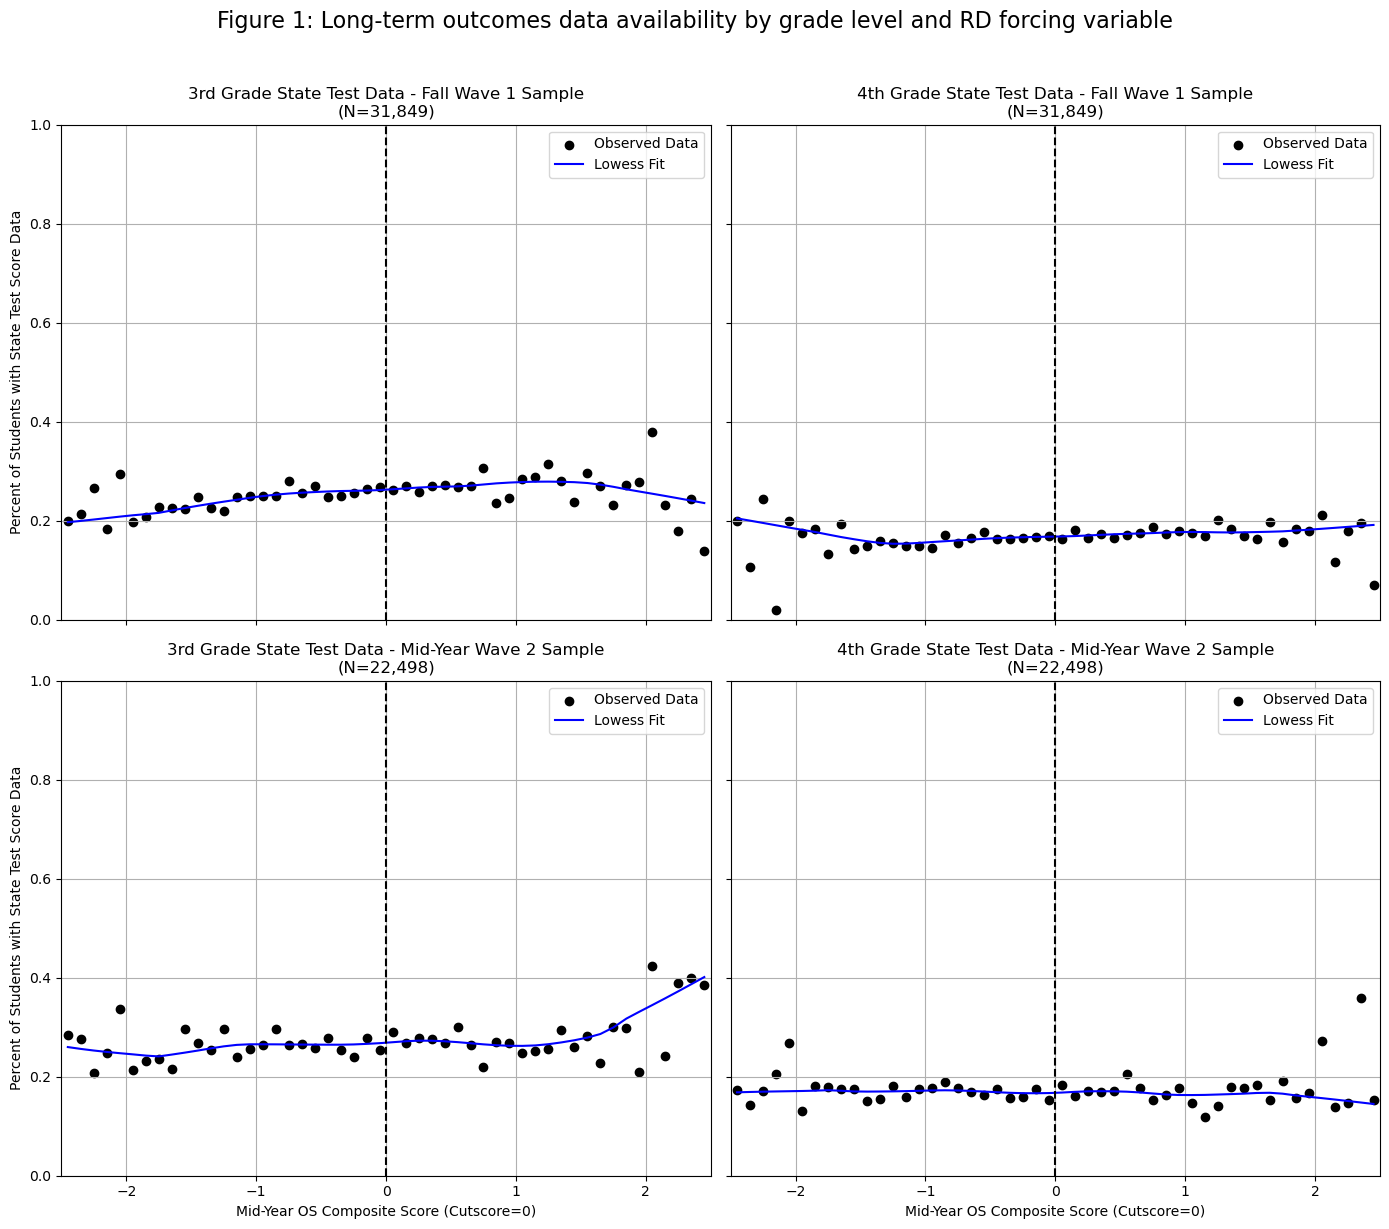

<Figure size 640x480 with 0 Axes>

In [202]:
# Bin forcing variables
bin_width = 0.1
bins = np.arange(-2.5, 2.6, bin_width)

# Add bins for RD analysis
df_clean["Fall_Bin"] = pd.cut(df_clean["Fall_OSscore_Cntrd"], bins=bins, include_lowest=True)
df_clean["MidYr_Bin"] = pd.cut(df_clean["MidYr_OSscore_Cntrd"], bins=bins, include_lowest=True)

# Calculate percentage of students with state test score data for each bin
def calculate_availability(df, score_col, bin_col):
    availability = df.groupby(bin_col)[score_col].mean().reset_index(name="Percent_Students")
    availability["Bin_Center"] = availability[bin_col].apply(lambda x: x.mid)
    return availability

fall_g3_availability = calculate_availability(df_clean, "HasG3ST", "Fall_Bin")
midyr_g3_availability = calculate_availability(df_clean, "HasG3ST", "MidYr_Bin")
fall_g4_availability = calculate_availability(df_clean, "HasG4ST", "Fall_Bin")
midyr_g4_availability = calculate_availability(df_clean, "HasG4ST", "MidYr_Bin")

# Helper function for lowess smoothing
def add_lowess(data, x_col, y_col):
    smoothed = lowess(data[y_col], data[x_col], frac=0.3)
    return smoothed[:, 0], smoothed[:, 1]

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 3rd Grade Fall
x, y = add_lowess(fall_g3_availability, "Bin_Center", "Percent_Students")
axes[0, 0].scatter(fall_g3_availability["Bin_Center"], fall_g3_availability["Percent_Students"], label="Observed Data", color="black")
axes[0, 0].plot(x, y, label="Lowess Fit", color="blue")
axes[0, 0].axvline(0, color="black", linestyle="--")
axes[0, 0].set_title("3rd Grade State Test Data - Fall Wave 1 Sample\n(N=31,849)")
axes[0, 0].set_ylabel("Percent of Students with State Test Score Data")

# 3rd Grade Mid-Year
x, y = add_lowess(midyr_g3_availability, "Bin_Center", "Percent_Students")
axes[1, 0].scatter(midyr_g3_availability["Bin_Center"], midyr_g3_availability["Percent_Students"], label="Observed Data", color="black")
axes[1, 0].plot(x, y, label="Lowess Fit", color="blue")
axes[1, 0].axvline(0, color="black", linestyle="--")
axes[1, 0].set_title("3rd Grade State Test Data - Mid-Year Wave 2 Sample\n(N=22,498)")
axes[1, 0].set_ylabel("Percent of Students with State Test Score Data")
axes[1, 0].set_xlabel("Mid-Year OS Composite Score (Cutscore=0)")

# 4th Grade Fall
x, y = add_lowess(fall_g4_availability, "Bin_Center", "Percent_Students")
axes[0, 1].scatter(fall_g4_availability["Bin_Center"], fall_g4_availability["Percent_Students"], label="Observed Data", color="black")
axes[0, 1].plot(x, y, label="Lowess Fit", color="blue")
axes[0, 1].axvline(0, color="black", linestyle="--")
axes[0, 1].set_title("4th Grade State Test Data - Fall Wave 1 Sample\n(N=31,849)")

# 4th Grade Mid-Year
x, y = add_lowess(midyr_g4_availability, "Bin_Center", "Percent_Students")
axes[1, 1].scatter(midyr_g4_availability["Bin_Center"], midyr_g4_availability["Percent_Students"], label="Observed Data", color="black")
axes[1, 1].plot(x, y, label="Lowess Fit", color="blue")
axes[1, 1].axvline(0, color="black", linestyle="--")
axes[1, 1].set_title("4th Grade State Test Data - Mid-Year Wave 2 Sample\n(N=22,498)")
axes[1, 1].set_xlabel("Mid-Year OS Composite Score (Cutscore=0)")

# Final formatting
for ax in axes.flatten():
    ax.set_ylim(0, 1)
    ax.set_xlim(-2.5, 2.5)
    ax.legend()
    ax.grid(True)

plt.suptitle("Figure 1: Long-term outcomes data availability by grade level and RD forcing variable", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

plt.savefig("/Users/salmahoumane/Documents/RDD/participation_rates.png")


In [260]:
# Define a function to calculate participation rates
def calculate_participation_rates(df, score_col, participation_col, bins):
    df = df.copy()
    df["bin"] = pd.cut(df[score_col], bins, include_lowest=True, labels=False)
    grouped = df.groupby("bin").agg(
        participation_rate=(participation_col, "mean"), # Average participation in each bin
        mean_score=(score_col, "mean") # Mean forcing variable in each bin
    ).dropna()
    return grouped.reset_index()

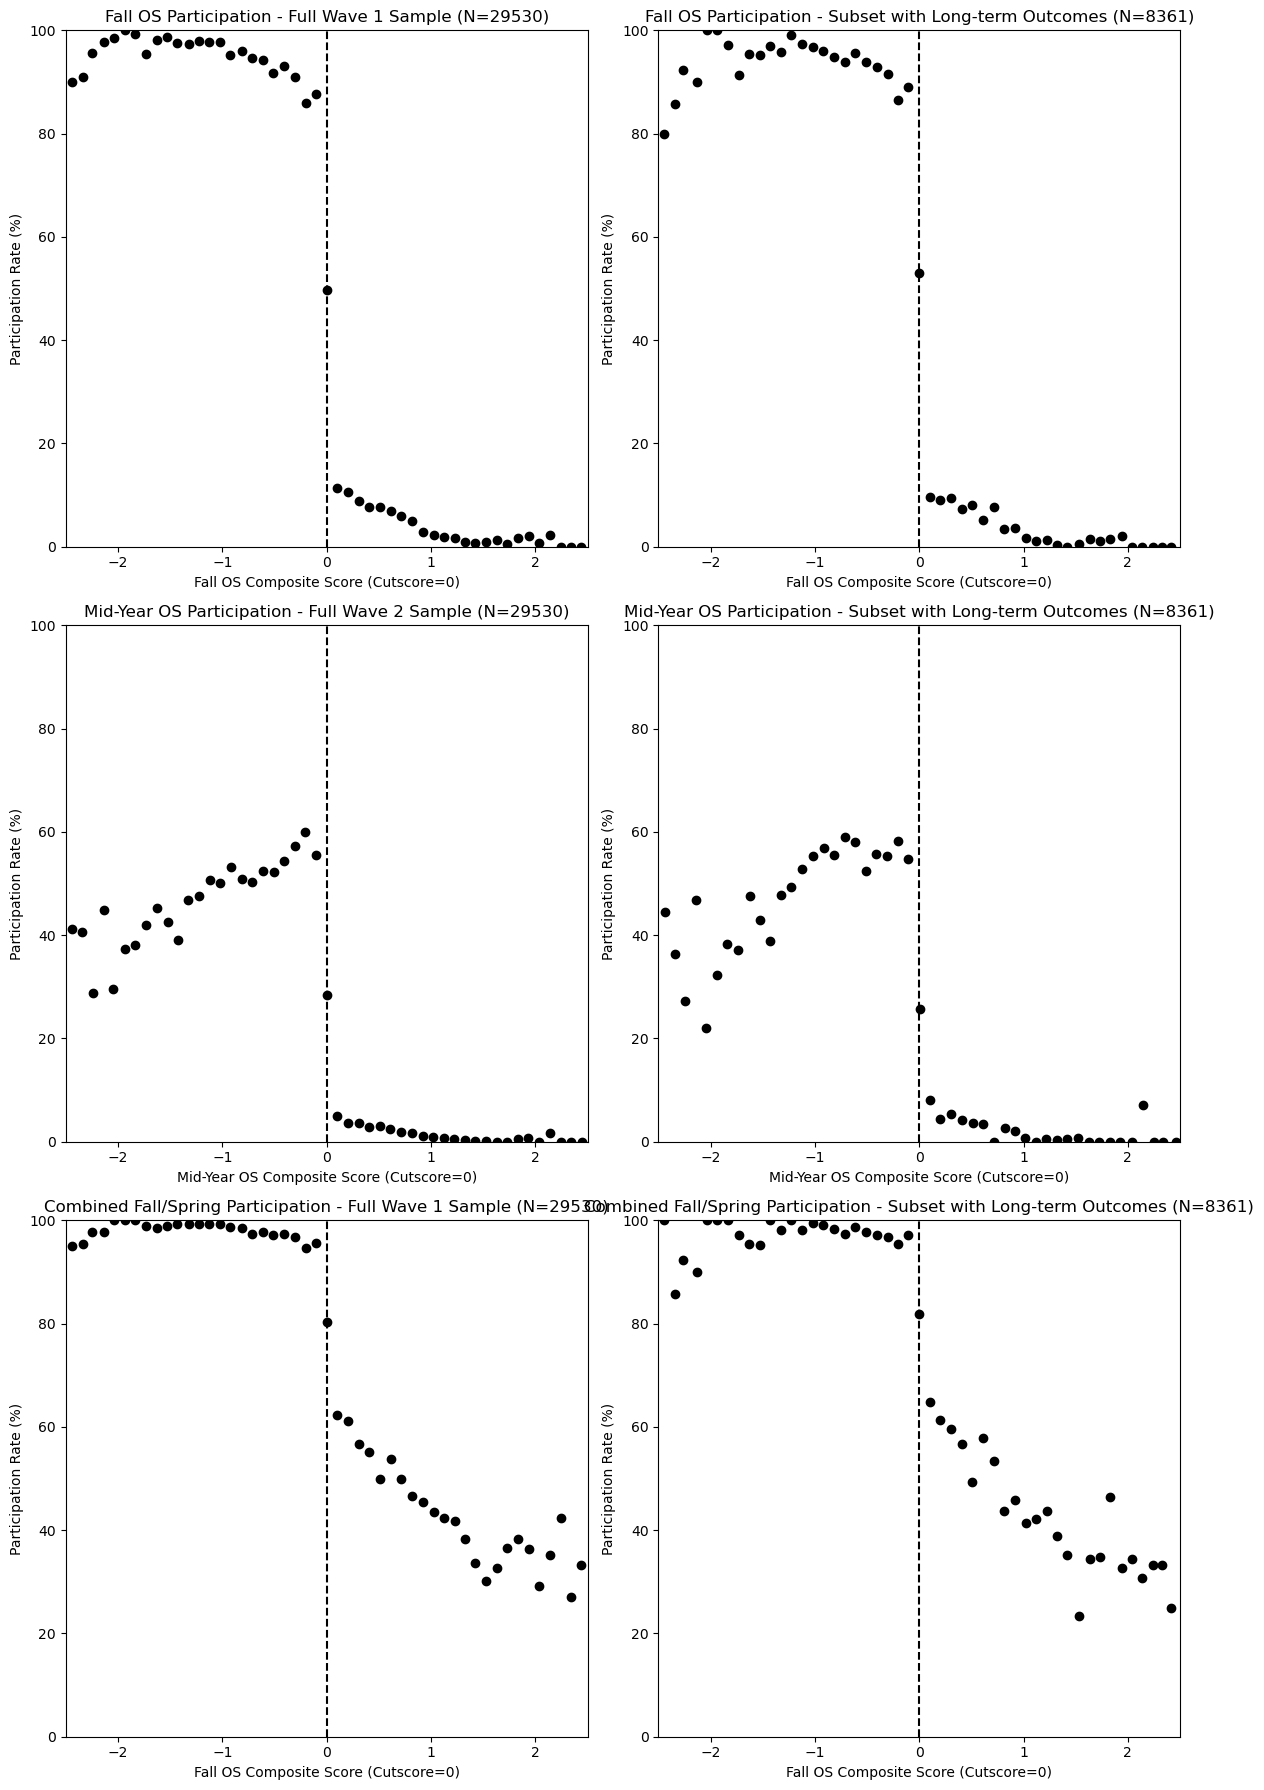

In [272]:
# Step 1: Filter datasets for full sample and subset with long-term outcomes
full_sample = df_clean.copy()
full_sample = full_sample.dropna(subset=["GotRRfirst", "GotRRsecond", "Fall_OSscore_Cntrd", "MidYr_OSscore_Cntrd","MidYr_BelowCut"])
# Ensure participation columns are Boolean
full_sample["GotRRfirst"] = full_sample["GotRRfirst"].astype(int).astype(bool)
full_sample["GotRRsecond"] = full_sample["GotRRsecond"].astype(int).astype(bool)


#Creating subset
subset_long_term = full_sample[(full_sample["HasG3ST"] == 1) | (full_sample["HasG4ST"] == 1)]

# Define bins between -2.5 and 2.5
bins = np.linspace(-2.5, 2.5, 50)

# Fall OS participation rates
fall_full = calculate_participation_rates(full_sample, "Fall_OSscore_Cntrd", "GotRRfirst", bins)
fall_subset = calculate_participation_rates(subset_long_term, "Fall_OSscore_Cntrd", "GotRRfirst", bins)

# Mid-Year OS participation rates
midyear_full = calculate_participation_rates(full_sample, "MidYr_OSscore_Cntrd", "GotRRsecond", bins)
midyear_subset = calculate_participation_rates(subset_long_term, "MidYr_OSscore_Cntrd", "GotRRsecond", bins)


# Combined Fall and Spring participation rates
combined_full_sample = full_sample.copy()
combined_full_sample["CombinedParticipation"] = combined_full_sample["GotRRfirst"] | combined_full_sample["GotRRsecond"]
combined_subset = subset_long_term.copy()
combined_subset["CombinedParticipation"] = combined_subset["GotRRfirst"] | combined_subset["GotRRsecond"]

# Calculate participation rates for combined data
combined_full = calculate_participation_rates(combined_full_sample, "Fall_OSscore_Cntrd", "CombinedParticipation", bins)
combined_subset = calculate_participation_rates(combined_subset, "Fall_OSscore_Cntrd", "CombinedParticipation", bins)

# Plot the graphs
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# Top row: Fall OS participation rates
axs[0, 0].scatter(fall_full["mean_score"], fall_full["participation_rate"] * 100, color="black")
axs[0, 0].set_title(f"Fall OS Participation - Full Wave 1 Sample (N={len(full_sample)})")
axs[0, 0].set_ylabel("Participation Rate (%)")
axs[0, 0].set_xlabel("Fall OS Composite Score (Cutscore=0)")
axs[0, 0].axvline(x=0, color="black", linestyle="--")
axs[0, 0].set_xlim(-2.5, 2.5)
axs[0, 0].set_ylim(0, 100)

axs[0, 1].scatter(fall_subset["mean_score"], fall_subset["participation_rate"] * 100, color="black")
axs[0, 1].set_title(f"Fall OS Participation - Subset with Long-term Outcomes (N={len(subset_long_term)})")
axs[0, 1].set_ylabel("Participation Rate (%)")
axs[0, 1].set_xlabel("Fall OS Composite Score (Cutscore=0)")
axs[0, 1].axvline(x=0, color="black", linestyle="--")
axs[0, 1].set_xlim(-2.5, 2.5)
axs[0, 1].set_ylim(0, 100)

# Middle row: Mid-Year OS participation rates
axs[1, 0].scatter(midyear_full["mean_score"], midyear_full["participation_rate"] * 100, color="black")
axs[1, 0].set_title(f"Mid-Year OS Participation - Full Wave 2 Sample (N={len(full_sample)})")
axs[1, 0].set_ylabel("Participation Rate (%)")
axs[1, 0].set_xlabel("Mid-Year OS Composite Score (Cutscore=0)")
axs[1, 0].axvline(x=0, color="black", linestyle="--")
axs[1, 0].set_xlim(-2.5, 2.5)
axs[1, 0].set_ylim(0, 100)

axs[1, 1].scatter(midyear_subset["mean_score"], midyear_subset["participation_rate"] * 100, color="black")
axs[1, 1].set_title(f"Mid-Year OS Participation - Subset with Long-term Outcomes (N={len(subset_long_term)})")
axs[1, 1].set_ylabel("Participation Rate (%)")
axs[1, 1].set_xlabel("Mid-Year OS Composite Score (Cutscore=0)")
axs[1, 1].axvline(x=0, color="black", linestyle="--")
axs[1, 1].set_xlim(-2.5, 2.5)
axs[1, 1].set_ylim(0, 100)

# Bottom row: Combined Fall and Spring participation rates
axs[2, 0].scatter(combined_full["mean_score"], combined_full["participation_rate"] * 100, color="black")
axs[2, 0].set_title(f"Combined Fall/Spring Participation - Full Wave 1 Sample (N={len(full_sample)})")
axs[2, 0].set_ylabel("Participation Rate (%)")
axs[2, 0].set_xlabel("Fall OS Composite Score (Cutscore=0)")
axs[2, 0].axvline(x=0, color="black", linestyle="--")
axs[2, 0].set_xlim(-2.5, 2.5)
axs[2, 0].set_ylim(0, 100)

axs[2, 1].scatter(combined_subset["mean_score"], combined_subset["participation_rate"] * 100, color="black")
axs[2, 1].set_title(f"Combined Fall/Spring Participation - Subset with Long-term Outcomes (N={len(subset_long_term)})")
axs[2, 1].set_ylabel("Participation Rate (%)")
axs[2, 1].set_xlabel("Fall OS Composite Score (Cutscore=0)")
axs[2, 1].axvline(x=0, color="black", linestyle="--")
axs[2, 1].set_xlim(-2.5, 2.5)
axs[2, 1].set_ylim(0, 100)

plt.tight_layout()
plt.show()


The graphs show that participation in Reading Recovery exhibits sharp and substantial discontinuities at the cutscore for both waves (Fall and Spring). These discontinuities are consistent across the full sample and the subset with long-term outcomes. This strongly supports the appropriateness of a Fuzzy RD design, where the forcing variable is an effective predictor of treatment assignment.

# Fuzzy RDD confirmation 

In [46]:
def create_bins(df, running_var, bin_width):
    """
    Create bins for the running variable to calculate local averages.
    """
    df['bin'] = np.floor(df[running_var] / bin_width) * bin_width
    return df

def plot_treatment_vs_forcing(df, forcing_var, treatment_var, bin_width):
    """
    Plot treatment probability vs. forcing variable with binned averages.
    """
    # Create bins and calculate treatment means within bins
    df_binned = create_bins(df.copy(), forcing_var, bin_width)
    bin_means = df_binned.groupby('bin')[treatment_var].mean().reset_index()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(bin_means['bin'], bin_means[treatment_var], color='blue', label=f'Bin = {bin_width}')
    plt.axvline(x=0, color='red', linestyle='--', label='Cutoff')
    plt.title(f'Treatment vs. Forcing Variable (Bin = {bin_width})')
    plt.xlabel(forcing_var)
    plt.ylabel('Treatment Probability')
    plt.legend()
    plt.show()


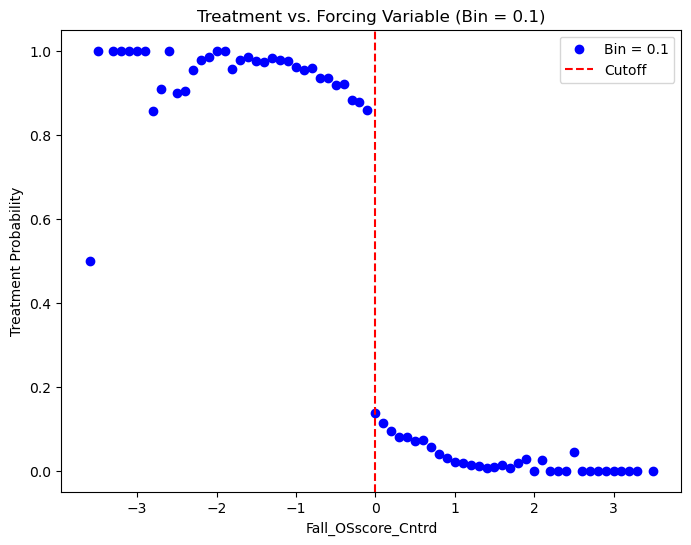

In [49]:
#Prepare dataset
plot_df = df_clean.copy()
plot_df = plot_df.dropna(subset=["GotRRfirst", "GotRRsecond", "Fall_OSscore_Cntrd", "MidYr_OSscore_Cntrd","MidYr_BelowCut"])
# Usage Fall
bin_width = 0.1  
plot_treatment_vs_forcing(plot_df, 'Fall_OSscore_Cntrd', 'GotRRfirst', bin_width)

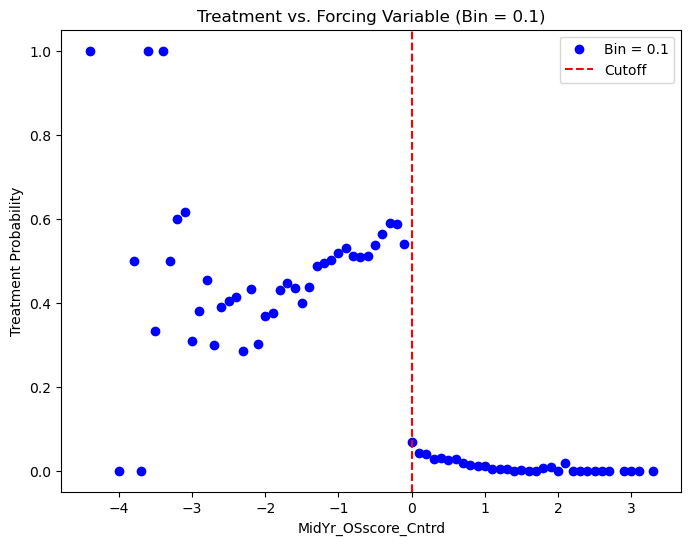

In [50]:
# Usage Midyear
bin_width = 0.1  
plot_treatment_vs_forcing(plot_df, 'MidYr_OSscore_Cntrd', 'GotRRsecond', bin_width)

## Forcing Variable: OS (FLI, FOWT, FCAP, FWV, FHRSW, FTRL)
The OS is the primary screening, diagnostic, and monitoring instrument for Reading Recovery. It is a one-to-one, teacher- administered, standardized assessment that includes six subscales: Letter Identification (FLI), Concepts about Print (FCAP), Ohio Word Test (FOWT), Writing Vocabulary (FWV), Hearing and Recording Sounds in Words (FHRSW), and Text Reading Level (FTRL). Reported test-retest and internal consistency reliability estimates for the OS range from moderate to high on the individual OS Tasks (Clay, 2005).

# Graphical Presentation: Density of the forcing variable

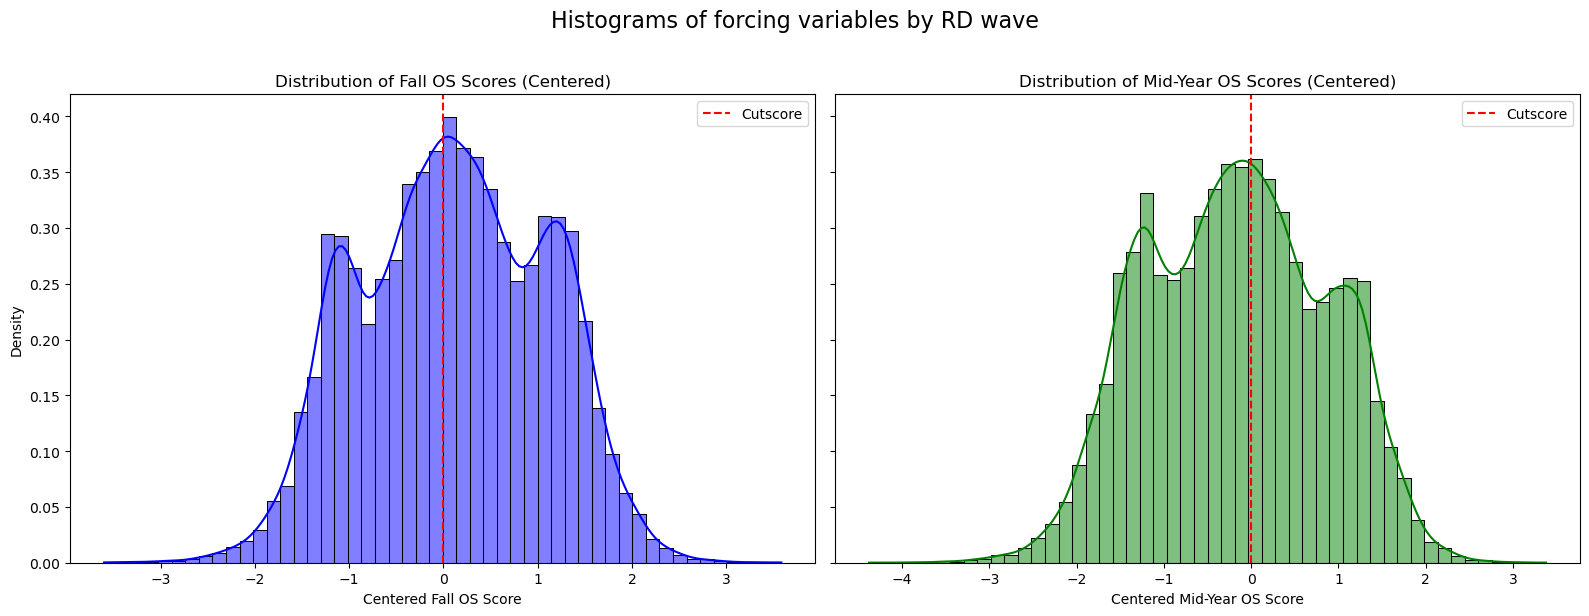

In [203]:
# Step 1: Data Preparation (ensure scores are centered around the cutscore)
fall_scores = df_clean["Fall_OSscore_Cntrd"].dropna()
midyear_scores = df_clean["MidYr_OSscore_Cntrd"].dropna()

# Step 2: Create Histograms with Density Overlay
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Fall OS Score Histogram
sns.histplot(fall_scores, bins=50, kde=True, ax=axes[0], color="blue", stat="density")
axes[0].axvline(0, color="red", linestyle="--", label="Cutscore")
axes[0].set_title("Distribution of Fall OS Scores (Centered)")
axes[0].set_xlabel("Centered Fall OS Score")
axes[0].set_ylabel("Density")
axes[0].legend()

# Mid-Year OS Score Histogram
sns.histplot(midyear_scores, bins=50, kde=True, ax=axes[1], color="green", stat="density")
axes[1].axvline(0, color="red", linestyle="--", label="Cutscore")
axes[1].set_title("Distribution of Mid-Year OS Scores (Centered)")
axes[1].set_xlabel("Centered Mid-Year OS Score")
axes[1].legend()

plt.suptitle("Histograms of forcing variables by RD wave", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


The McCrary test examines whether there is a discontinuity in the density of the forcing variable around the cutpoint (cutscore = 0). This is important in regression discontinuity (RD) designs to ensure that treatment assignment is not manipulated around the cutscore

In [54]:
from scipy.stats import gaussian_kde

# Step 3: McCrary Test (Visual Approximation)
def mccrary_test(data, cutpoint=0):
    """Simple McCrary test: Compare densities above and below cutpoint."""
    below_cut = data[data <= cutpoint]
    above_cut = data[data > cutpoint]
    
    kde_below = gaussian_kde(below_cut)
    kde_above = gaussian_kde(above_cut)
    
    # Evaluate density near the cutpoint
    density_below = kde_below(cutpoint)[0]  # Extract scalar value
    density_above = kde_above(cutpoint)[0]  # Extract scalar value
    ratio = density_above / density_below

    return density_below, density_above, ratio

# Assuming fall_scores and midyear_scores are 1D numpy arrays or pandas Series
fall_density_below, fall_density_above, fall_ratio = mccrary_test(fall_scores.values, cutpoint=0)
midyear_density_below, midyear_density_above, midyear_ratio = mccrary_test(midyear_scores.values, cutpoint=0)

# Print Results
print("McCrary Test Results:")
print(f"Fall OS Scores: Density Below Cutscore = {fall_density_below:.4f}, Density Above Cutscore = {fall_density_above:.4f}, Ratio = {fall_ratio:.4f}")
print(f"Mid-Year OS Scores: Density Below Cutscore = {midyear_density_below:.4f}, Density Above Cutscore = {midyear_density_above:.4f}, Ratio = {midyear_ratio:.4f}")

# Interpretation: A ratio close to 1 indicates no significant discontinuity near the cutscore.

McCrary Test Results:
Fall OS Scores: Density Below Cutscore = 0.4191, Density Above Cutscore = 0.3608, Ratio = 0.8608
Mid-Year OS Scores: Density Below Cutscore = 0.3284, Density Above Cutscore = 0.4046, Ratio = 1.2319


- The ratios for both Fall (0.8608) and Mid-Year (1.2319) OS scores do not provide evidence of systematic manipulation or clustering of scores around the cutscore.
- These results suggest the forcing variable (OS scores) is continuous around the cutscore, supporting the validity of the regression discontinuity design (RDD).
- These McCrary test results indicate that students just above and just below the cutscore are comparable, reinforcing the causal interpretation of treatment effects in this analysis.

# Distribution of the outcome variables

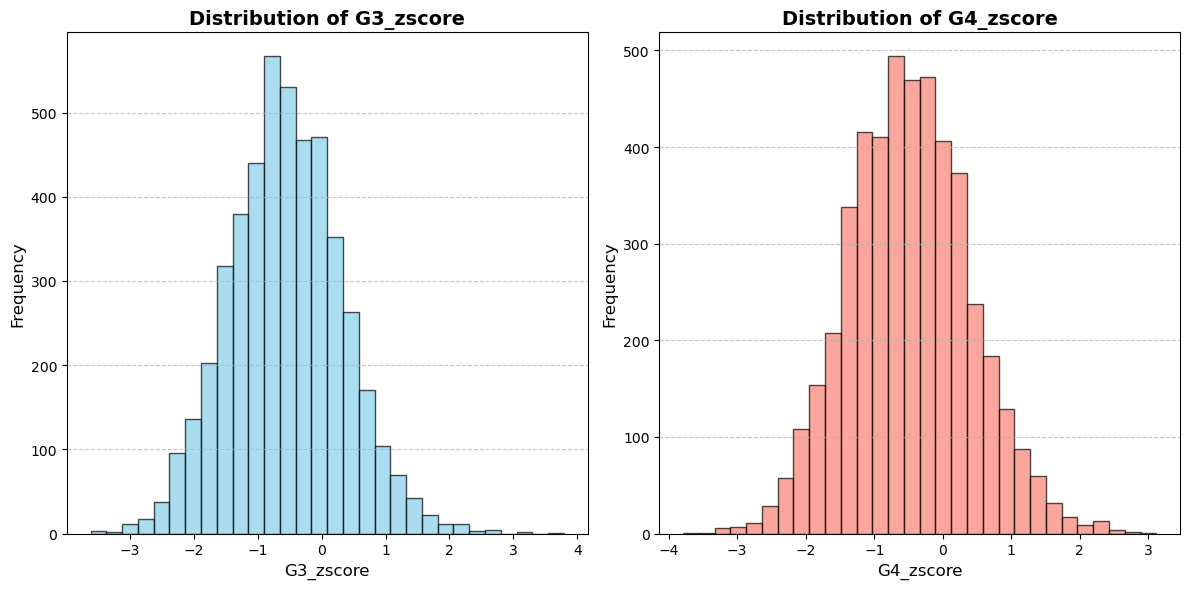

In [313]:
# Create histograms for G3_zscore and G4_zscore
plt.figure(figsize=(12, 6))

# Histogram for G3_zscore
plt.subplot(1, 2, 1)
plt.hist(df_clean['G3_zscore'].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of G3_zscore', fontsize=14, weight='bold')
plt.xlabel('G3_zscore', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Histogram for G4_zscore
plt.subplot(1, 2, 2)
plt.hist(df_clean['G4_zscore'].dropna(), bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Distribution of G4_zscore', fontsize=14, weight='bold')
plt.xlabel('G4_zscore', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Optimal Bandwidth using Cross validation

# Allowing for 2 bandwiths on different sides

In [153]:
def cross_validation_bandwidth_separate(data, forcing_var, outcome_var, left_bandwidths, right_bandwidths, cutoff=0):
    """
    Perform cross-validation to determine the optimal separate bandwidths (left and right of the cutoff) 
    for local regression.

    Parameters:
        data (pd.DataFrame): The dataset containing the variables.
        forcing_var (str): The name of the forcing variable (e.g., "Fall_OSscore_Cntrd").
        outcome_var (str): The name of the outcome variable (e.g., "G3_zscore").
        left_bandwidths (list or array-like): A list of bandwidths to evaluate on the left of the cutoff.
        right_bandwidths (list or array-like): A list of bandwidths to evaluate on the right of the cutoff.
        cutoff (float): The cutoff value for the forcing variable (default is 0).

    Returns:
        tuple: A tuple containing the optimal left and right bandwidths.
        dict: A dictionary where keys are (h_left, h_right) tuples and values are their MSE scores.
    """
    mse_scores = {}
    data = data.dropna(subset=[forcing_var, outcome_var])
    
    # Loop through all combinations of left and right bandwidths
    for h_left in left_bandwidths:
        for h_right in right_bandwidths:
            predictions = []
            actuals = []
            
            # Perform leave-one-out cross-validation
            for idx, current_point in data.iterrows():
                # Exclude the current observation
                data_leave_one_out = data.drop(index=idx)
                x_i = current_point[forcing_var]
                y_i = current_point[outcome_var]
                
                # Select data within the bandwidth, based on the cutoff
                if x_i < cutoff:
                    subset = data_leave_one_out[
                        (data_leave_one_out[forcing_var] < cutoff) &
                        (data_leave_one_out[forcing_var] >= x_i - h_left)
                    ]
                else:
                    subset = data_leave_one_out[
                        (data_leave_one_out[forcing_var] > cutoff) &
                        (data_leave_one_out[forcing_var] <= x_i + h_right)
                    ]
                
                # Skip iteration if not enough data is available
                if len(subset) < 2:
                    continue
                
                # Calculate the local average as the prediction
                predicted_y = subset[outcome_var].mean()
                predictions.append(predicted_y)
                actuals.append(y_i)
            
            # Compute the Mean Squared Error (MSE) for the current bandwidth combination
            mse_scores[(h_left, h_right)] = mean_squared_error(actuals, predictions) if predictions else float('inf')
    
    # Find the combination of bandwidths with the lowest MSE
    optimal_bandwidth = min(mse_scores, key=mse_scores.get)
    
    return optimal_bandwidth, mse_scores


In [154]:
# Example data
forcing_var = "Fall_OSscore_Cntrd"
outcome_var = "G3_zscore"
cutoff = 0

# Define bandwidth ranges
left_bandwidths = np.arange(0.1, 1.1, 0.1)  # Left bandwidths from 0.1 to 1.0 with step 0.1
right_bandwidths = np.arange(0.1, 1.1, 0.1)  # Right bandwidths from 0.1 to 1.0 with step 0.1

# Find optimal bandwidths
optimal_bandwidth, mse_scores = cross_validation_bandwidth_separate(
    plot_df, forcing_var, outcome_var, left_bandwidths, right_bandwidths, cutoff
)

print(f"Optimal Left and Right Bandwidths: {optimal_bandwidth}")
print("MSE Scores for All Bandwidth Combinations:")
for bw_pair, mse in mse_scores.items():
    print(f"Left: {bw_pair[0]}, Right: {bw_pair[1]}, MSE: {mse:.4f}")


Optimal Left and Right Bandwidths: (0.6000000000000001, 0.5)
MSE Scores for All Bandwidth Combinations:
Left: 0.1, Right: 0.1, MSE: 0.7757
Left: 0.1, Right: 0.2, MSE: 0.7756
Left: 0.1, Right: 0.30000000000000004, MSE: 0.7755
Left: 0.1, Right: 0.4, MSE: 0.7755
Left: 0.1, Right: 0.5, MSE: 0.7753
Left: 0.1, Right: 0.6000000000000001, MSE: 0.7754
Left: 0.1, Right: 0.7000000000000001, MSE: 0.7754
Left: 0.1, Right: 0.8, MSE: 0.7754
Left: 0.1, Right: 0.9, MSE: 0.7754
Left: 0.1, Right: 1.0, MSE: 0.7754
Left: 0.2, Right: 0.1, MSE: 0.7755
Left: 0.2, Right: 0.2, MSE: 0.7754
Left: 0.2, Right: 0.30000000000000004, MSE: 0.7753
Left: 0.2, Right: 0.4, MSE: 0.7753
Left: 0.2, Right: 0.5, MSE: 0.7751
Left: 0.2, Right: 0.6000000000000001, MSE: 0.7752
Left: 0.2, Right: 0.7000000000000001, MSE: 0.7752
Left: 0.2, Right: 0.8, MSE: 0.7752
Left: 0.2, Right: 0.9, MSE: 0.7752
Left: 0.2, Right: 1.0, MSE: 0.7752
Left: 0.30000000000000004, Right: 0.1, MSE: 0.7754
Left: 0.30000000000000004, Right: 0.2, MSE: 0.7753
Le

In [162]:
# Example data
forcing_var = "MidYr_OSscore_Cntrd"
outcome_var = "G3_zscore"
cutoff = 0

# Define bandwidth ranges
left_bandwidths = np.arange(0.1, 1.1, 0.1)  # Left bandwidths from 0.1 to 1.0 with step 0.1
right_bandwidths = np.arange(0.1, 1.1, 0.1)  # Right bandwidths from 0.1 to 1.0 with step 0.1

# Find optimal bandwidths
optimal_bandwidth, mse_scores = cross_validation_bandwidth_separate(
    plot_df, forcing_var, outcome_var, left_bandwidths, right_bandwidths, cutoff
)

print(f"Optimal Left and Right Bandwidths: {optimal_bandwidth}")
print("MSE Scores for All Bandwidth Combinations:")
for bw_pair, mse in mse_scores.items():
    print(f"Left: {bw_pair[0]}, Right: {bw_pair[1]}, MSE: {mse:.4f}")

Optimal Left and Right Bandwidths: (0.7000000000000001, 0.6000000000000001)
MSE Scores for All Bandwidth Combinations:
Left: 0.1, Right: 0.1, MSE: 0.7832
Left: 0.1, Right: 0.2, MSE: 0.7833
Left: 0.1, Right: 0.30000000000000004, MSE: 0.7832
Left: 0.1, Right: 0.4, MSE: 0.7832
Left: 0.1, Right: 0.5, MSE: 0.7831
Left: 0.1, Right: 0.6000000000000001, MSE: 0.7830
Left: 0.1, Right: 0.7000000000000001, MSE: 0.7831
Left: 0.1, Right: 0.8, MSE: 0.7830
Left: 0.1, Right: 0.9, MSE: 0.7831
Left: 0.1, Right: 1.0, MSE: 0.7830
Left: 0.2, Right: 0.1, MSE: 0.7829
Left: 0.2, Right: 0.2, MSE: 0.7830
Left: 0.2, Right: 0.30000000000000004, MSE: 0.7829
Left: 0.2, Right: 0.4, MSE: 0.7829
Left: 0.2, Right: 0.5, MSE: 0.7828
Left: 0.2, Right: 0.6000000000000001, MSE: 0.7827
Left: 0.2, Right: 0.7000000000000001, MSE: 0.7827
Left: 0.2, Right: 0.8, MSE: 0.7827
Left: 0.2, Right: 0.9, MSE: 0.7828
Left: 0.2, Right: 1.0, MSE: 0.7827
Left: 0.30000000000000004, Right: 0.1, MSE: 0.7825
Left: 0.30000000000000004, Right: 0.2,

## Only alloying for one bandwidth on both sides of the cutoff

In [115]:
def cross_validation_bandwidth(data, forcing_var, outcome_var, bandwidths, cutoff=0):
    """
    Perform cross-validation to determine the optimal bandwidth for local regression.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the variables.
        forcing_var (str): The name of the forcing variable (e.g., "Fall_OSscore_Cntrd").
        outcome_var (str): The name of the outcome variable (e.g., "G3_zscore").
        bandwidths (list or array-like): A list of bandwidths to evaluate.
        cutoff (float): The cutoff value for the forcing variable (default is 0).
    
    Returns:
        float: The optimal bandwidth with the lowest cross-validation MSE.
        dict: A dictionary where keys are bandwidths and values are their MSE scores.
    """
    mse_scores = {}
    data = data.dropna(subset=[forcing_var, outcome_var])
    for h in bandwidths:
        predictions = []
        actuals = []
        
        # Perform leave-one-out cross-validation
        for idx, current_point in data.iterrows():
            # Exclude the current observation
            data_leave_one_out = data.drop(index=idx)
            x_i = current_point[forcing_var]
            y_i = current_point[outcome_var]
            
            # Select data within the bandwidth, based on the cutoff
            if x_i < cutoff:
                subset = data_leave_one_out[
                    (data_leave_one_out[forcing_var] < cutoff) &
                    (data_leave_one_out[forcing_var] >= x_i - h)
                ]
            else:
                subset = data_leave_one_out[
                    (data_leave_one_out[forcing_var] > cutoff) &
                    (data_leave_one_out[forcing_var] <= x_i + h)
                ]
            
            # Skip iteration if not enough data is available
            if len(subset) < 2:
                continue
            
            # Calculate the local average as the prediction
            predicted_y = subset[outcome_var].mean()
            predictions.append(predicted_y)
            actuals.append(y_i)
        
        # Compute the Mean Squared Error (MSE) for the current bandwidth
        mse_scores[h] = mean_squared_error(actuals, predictions) if predictions else float('inf')

    # Find the bandwidth with the lowest MSE
    optimal_bandwidth = min(mse_scores, key=mse_scores.get)
    
    return optimal_bandwidth, mse_scores



Optimal Bandwidth: 0.6
MSE Scores: {0.1: 0.775737961313286, 0.2: 0.7753853242812324, 0.3: 0.775205178494863, 0.35: 0.7751580088674168, 0.4: 0.7751746194774582, 0.5: 0.774980115039897, 0.6: 0.7749153491364936, 0.7648: 0.7749455475442226, 0.9: 0.7750102764226123}


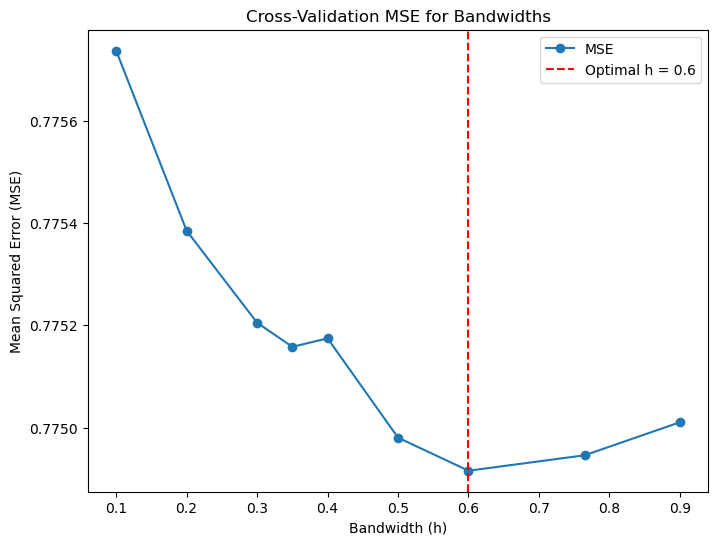

In [119]:
# Parameters
forcing_var = "Fall_OSscore_Cntrd"  # Forcing variable
outcome_var = "G3_zscore"           # Outcome variable
bandwidths = [0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7648, 0.9]
optimal_bandwidth, mse_scores = cross_validation_bandwidth(plot_df, forcing_var, outcome_var, bandwidths)

print(f"Optimal Bandwidth: {optimal_bandwidth}")
print(f"MSE Scores: {mse_scores}")

# Plot the new MSE results
plt.figure(figsize=(8, 6))
plt.plot(mse_scores.keys(), mse_scores.values(), marker="o", label="MSE")
plt.xlabel("Bandwidth (h)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Cross-Validation MSE for Bandwidths")
plt.axvline(optimal_bandwidth, color="red", linestyle="--", label=f"Optimal h = {optimal_bandwidth}")
plt.legend()
plt.show()


Optimal Bandwidth: 0.6
MSE Scores: {0.1: 0.7715867169783494, 0.15: 0.7715229297061258, 0.2: 0.7714518852923888, 0.25: 0.7712823829381262, 0.3: 0.771122970678445, 0.35: 0.7710630324370806, 0.4: 0.7710274623291543, 0.45: 0.7709161757122683, 0.5: 0.770884969077856, 0.6: 0.7707755646569041, 0.8967: 0.7708350285851834, 0.9: 0.7708299209647989}


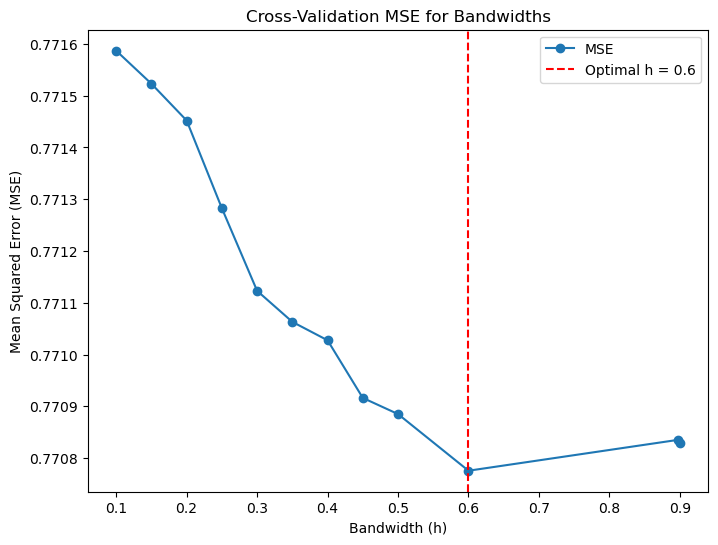

In [118]:
# Parameters mid year
forcing_var = "MidYr_OSscore_Cntrd"  # Forcing variable
outcome_var = "G3_zscore"           # Outcome variable
bandwidths = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8967, 0.9]
optimal_bandwidth, mse_scores = cross_validation_bandwidth(df_clean, forcing_var, outcome_var, bandwidths)

print(f"Optimal Bandwidth: {optimal_bandwidth}")
print(f"MSE Scores: {mse_scores}")

# Plot the new MSE results
plt.figure(figsize=(8, 6))
plt.plot(mse_scores.keys(), mse_scores.values(), marker="o", label="MSE")
plt.xlabel("Bandwidth (h)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Cross-Validation MSE for Bandwidths")
plt.axvline(optimal_bandwidth, color="red", linestyle="--", label=f"Optimal h = {optimal_bandwidth}")
plt.legend()
plt.show()

## For both midyear and fall, the optimal bandwidth is 0.6 because it has the lowest MSE.
##### The authors bandwiths were: bandwidth_wave_1 = 0.7648 and bandwidth_wave_2 = 0.8967

# Parametric RD Design

In [127]:
def plot_scatter_with_polynomial_fit(data, forcing_var, outcome_var, bin_width, degree, title, cutoff=0):
    """
    Create a scatter plot of local averages with a polynomial fit.
    
    Parameters:
    - data: DataFrame containing the variables.
    - forcing_var: Name of the forcing variable
    - outcome_var: Name of the outcome variable
    - bin_width: Width of each bin for local averages.
    - degree: Degree of the polynomial for the fit.
    - title: Title of the plot.
    - cutoff: The cutoff value for the forcing variable.
    """
    # Step 1: Remove rows with NaN values in the relevant columns
    data = data.dropna(subset=[forcing_var, outcome_var])

    # Step 2: Create bins and calculate local averages
    data['bin'] = (data[forcing_var] // bin_width) * bin_width
    bin_means = data.groupby('bin')[outcome_var].mean().reset_index()
    
    # Step 3: Prepare data for polynomial regression
    X = bin_means['bin'].values.reshape(-1, 1)  # Binned forcing variable
    y = bin_means[outcome_var].values          # Local averages of outcome variable

    # Polynomial feature transformation
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Fit polynomial regression
    model = LinearRegression()
    model.fit(X_poly, y)

    # Generate predictions for the fit
    X_range = np.linspace(data[forcing_var].min(), data[forcing_var].max(), 500).reshape(-1, 1)
    X_range_poly = poly.transform(X_range)
    y_pred = model.predict(X_range_poly)

    # Step 4: Plot the scatter plot and the polynomial fit
    plt.figure(figsize=(10, 6))
    plt.scatter(bin_means['bin'], bin_means[outcome_var], label="Local Averages", color="blue", alpha=0.7)
    plt.plot(X_range, y_pred, label=f"Polynomial Fit (Degree={degree})", color="red", linewidth=2)

    # Add cutoff line
    plt.axvline(x=cutoff, color="black", linestyle="--", linewidth=1.5, label="Cutoff")

    # Formatting
    plt.title(title, fontsize=14)
    plt.xlabel(forcing_var, fontsize=12)
    plt.ylabel(outcome_var, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/4147605203.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = (data[forcing_var] // bin_width) * bin_width


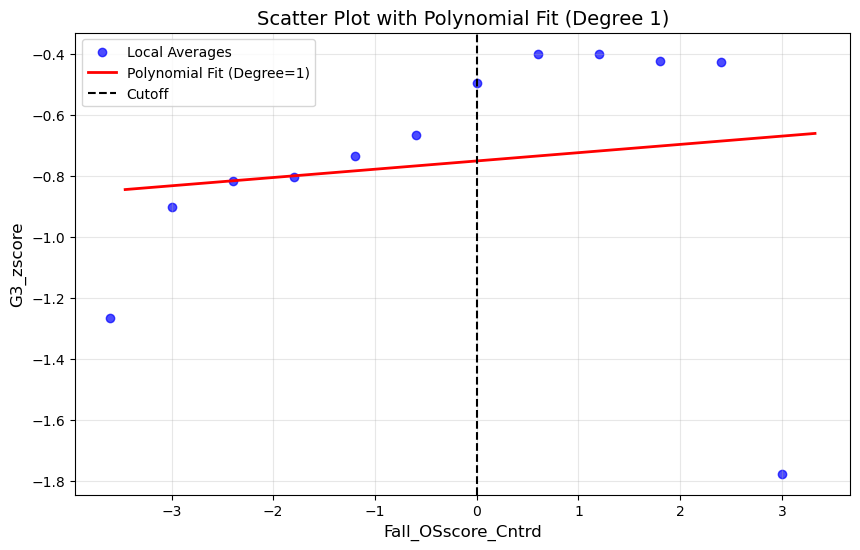

In [121]:
# Fall usage
# Parameters
forcing_var = "Fall_OSscore_Cntrd"  # Forcing variable
outcome_var = "G3_zscore"           # Outcome variable
bin_width = 0.6                    # Bin width for local averages
degree = 1                          # Degree of the polynomial
title = "Scatter Plot with Polynomial Fit (Degree 1)"  # Plot title

# Call the function
plot_scatter_with_polynomial_fit(df_clean, forcing_var, outcome_var, bin_width, degree, title)

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/4147605203.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = (data[forcing_var] // bin_width) * bin_width


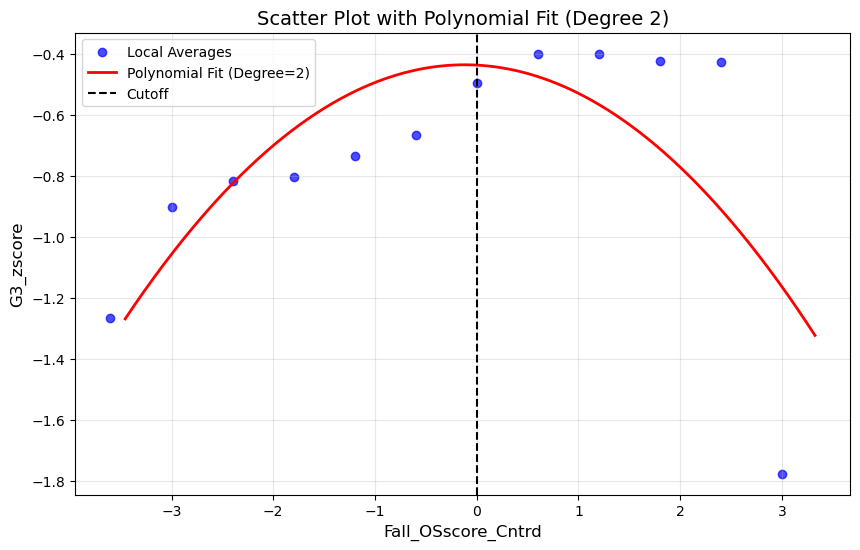

In [120]:
# Fall usage
# Parameters
forcing_var = "Fall_OSscore_Cntrd"  # Forcing variable
outcome_var = "G3_zscore"           # Outcome variable
bin_width = 0.6                    # Bin width for local averages
degree = 2                          # Degree of the polynomial
title = "Scatter Plot with Polynomial Fit (Degree 2)"  # Plot title

# Call the function
plot_scatter_with_polynomial_fit(df_clean, forcing_var, outcome_var, bin_width, degree, title)

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/4147605203.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = (data[forcing_var] // bin_width) * bin_width


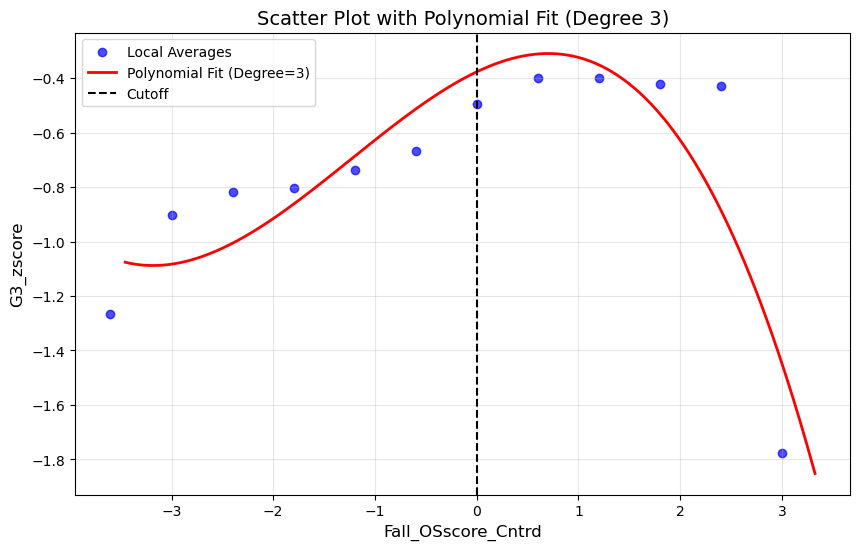

In [122]:
# Fall usage
# Parameters
forcing_var = "Fall_OSscore_Cntrd"  # Forcing variable
outcome_var = "G3_zscore"           # Outcome variable
bin_width = 0.6                  # Bin width for local averages
degree = 3                          # Degree of the polynomial
title = "Scatter Plot with Polynomial Fit (Degree 3)"  # Plot title

# Call the function
plot_scatter_with_polynomial_fit(df_clean, forcing_var, outcome_var, bin_width, degree, title)

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/4147605203.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = (data[forcing_var] // bin_width) * bin_width


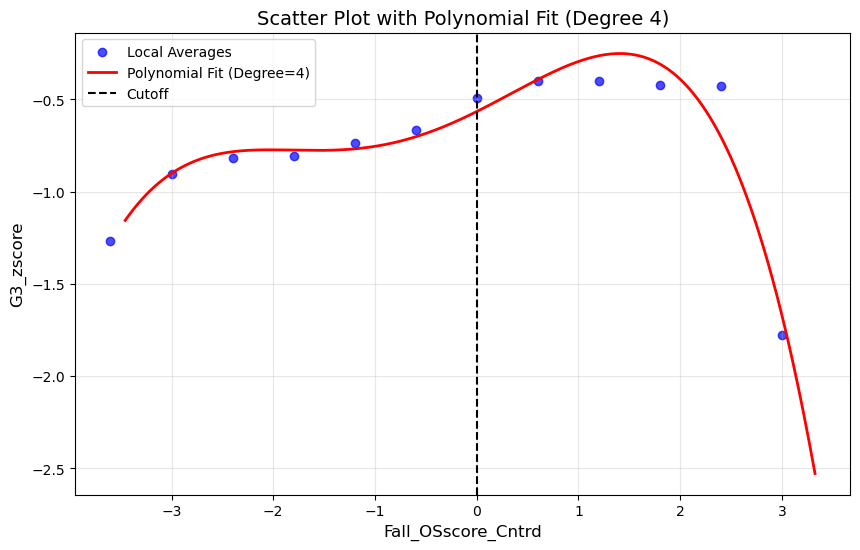

In [123]:
# Fall usage
# Parameters
forcing_var = "Fall_OSscore_Cntrd"  # Forcing variable
outcome_var = "G3_zscore"           # Outcome variable
bin_width = 0.6                    # Bin width for local averages
degree = 4                         # Degree of the polynomial
title = "Scatter Plot with Polynomial Fit (Degree 4)"  # Plot title

# Call the function
plot_scatter_with_polynomial_fit(df_clean, forcing_var, outcome_var, bin_width, degree, title)

## Fall: Compare Different Polynomial Degrees

In [128]:
def calculate_aic_for_polynomials(df, forcing_var, outcome_var, max_degree):
    """
    Calculate AIC for polynomial fits of varying degrees on both sides of the cutoff.
    
    Parameters:
    - df: DataFrame containing the data.
    - forcing_var: Name of the forcing variable
    - outcome_var: Name of the outcome variable
    - max_degree: Maximum degree of the polynomial to evaluate.
    
    Returns:
    - aic_values: A list of tuples (degree, combined AIC).
    """
    # Remove rows with NaN values
    df = df.dropna(subset=[forcing_var, outcome_var])

    # Split data at the cutoff
    left_data = df[df[forcing_var] < 0]
    right_data = df[df[forcing_var] > 0]

    aic_values = []

    for degree in range(1, max_degree + 1):
        # Polynomial fit for the left side
        left_X = sm.add_constant(np.vander(left_data[forcing_var], degree + 1, increasing=True))
        left_y = left_data[outcome_var]
        left_model = sm.OLS(left_y, left_X).fit()

        # Polynomial fit for the right side
        right_X = sm.add_constant(np.vander(right_data[forcing_var], degree + 1, increasing=True))
        right_y = right_data[outcome_var]
        right_model = sm.OLS(right_y, right_X).fit()

        # Combine AICs for left and right fits
        combined_aic = left_model.aic + right_model.aic
        aic_values.append((degree, combined_aic))
        print(f"Degree {degree}: Combined AIC = {combined_aic}")

    return aic_values

Degree 1: Combined AIC = 20717.895343453656
Degree 2: Combined AIC = 20717.20431958812
Degree 3: Combined AIC = 20718.805524201973
Degree 4: Combined AIC = 20720.907197522218


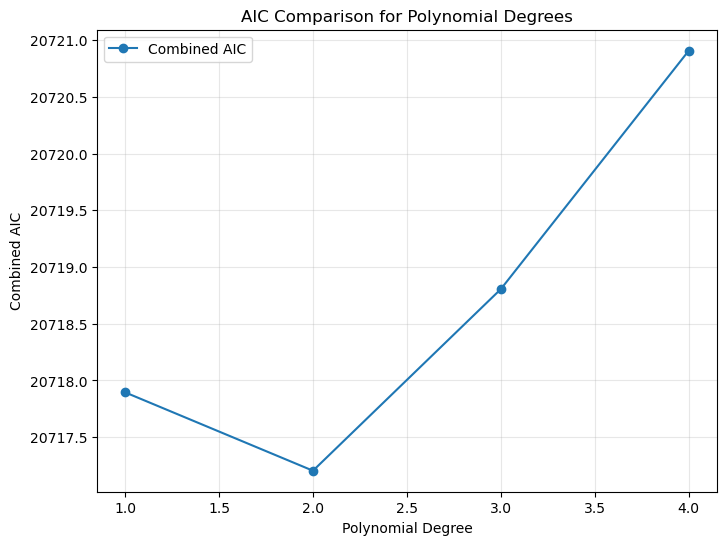

In [125]:
# Fall Example
max_degree = 4
aic_values = calculate_aic_for_polynomials(plot_df, 'Fall_OSscore_Cntrd', 'G3_zscore', max_degree)

# Plot the AIC values for comparison
degrees, aics = zip(*aic_values)
plt.figure(figsize=(8, 6))
plt.plot(degrees, aics, marker='o', label='Combined AIC')
plt.title('AIC Comparison for Polynomial Degrees')
plt.xlabel('Polynomial Degree')
plt.ylabel('Combined AIC')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Degree 1: Combined AIC = 20786.35743294329
Degree 2: Combined AIC = 20785.76009964197
Degree 3: Combined AIC = 20789.27725130187
Degree 4: Combined AIC = 20791.50209890715


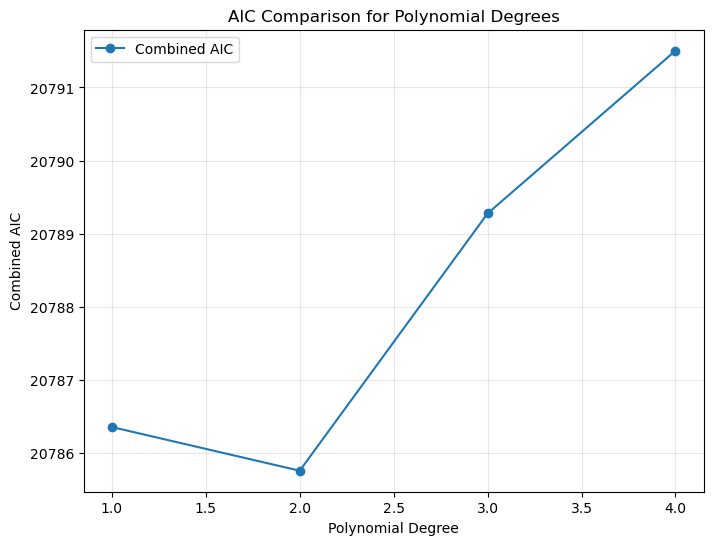

In [129]:
# Fall Example
max_degree = 4
aic_values = calculate_aic_for_polynomials(plot_df, 'MidYr_OSscore_Cntrd', 'G3_zscore', max_degree)

# Plot the AIC values for comparison
degrees, aics = zip(*aic_values)
plt.figure(figsize=(8, 6))
plt.plot(degrees, aics, marker='o', label='Combined AIC')
plt.title('AIC Comparison for Polynomial Degrees')
plt.xlabel('Polynomial Degree')
plt.ylabel('Combined AIC')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## For both fall and midyear, the best model is that of degree 2 because it has the lowest AIC.

In [198]:
# Save the DataFrame as a .dta file
df_regression.to_stata("df_regression.dta", write_index=False)

/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/173381153.py:2: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    Fall_OSscore_Cntrd^2   ->   _0Fall_OSscore_Cntrd_2
    Fall_OSscore_Cntrd^3   ->   _1Fall_OSscore_Cntrd_3
    interaction^2   ->   _2interaction_2

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  df_regression.to_stata("df_regression.dta", write_index=False)
/var/folders/6s/jtyjmwvn4wz6q7x39lwzwzsm0000gn/T/ipykernel_8403/173381153.py:2: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column Fall_Bin contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  df_regression.to_stata("df_regression

In [199]:
# Provide a download link
display(FileLink("df_regression.dta"))

/Users/salmahoumane/Documents/df_regression.dta

# Non-Parametric RD design

We will now Check whether the outcome (G3_zscore) changes discontinuously at the cutoff by calculating local averages of the outcome variable within bins

For different waves (fall and midyear) and different outcomes short-term (3rd grade), we experiment with different bin sizes [0.5, 0.1, 0.05, 0.01] to observe how it impacts the trend.

We use LOWESS (Locally Weighted Scatterplot Smoothing) to create a nonparametric fit for the outcome variable as a function of the forcing variable. LOWESS fits a smooth curve through the data without assuming a specific functional form (e.g., linear, quadratic, etc.). Instead, it relies on local regressions to approximate the relationship between the variables.
- While the binned means are not part of the LOWESS fit, plotting them alongside the smoothed lines helps visualize how well the LOWESS curve aligns with the local averages.

# Fraction 0.3: 
The frac parameter controls the proportion of the data used in each local regression. A smaller frac results in more localized smoothing (more sensitive to data variations), while a larger frac produces a smoother curve (less sensitive to local fluctuations).

In [217]:
def calculate_bin_means(df, outcome, forcing_var, bin_width):
    """
    Calculate the mean outcome for each bin of the forcing variable.
    """
    df[f'bin_{bin_width}'] = (df[forcing_var] // bin_width) * bin_width
    bin_means = df.groupby(f'bin_{bin_width}')[outcome].mean().reset_index()
    return bin_means

def plot_bin_scatter_with_lowess_gap(df, forcing_var, outcome, bin_means, bin_width, title, ax=None):
    """
    Plot the binned means along with separate LOWESS smoothing for left and right of the cutoff.
    Parameters:
        df (pd.DataFrame): The data frame containing the data.
        forcing_var (str): The forcing variable (independent variable).
        outcome (str): The outcome variable (dependent variable).
        bin_means (pd.DataFrame): Data frame containing binned means.
        bin_width (float): The bin width used for grouping.
        title (str): The title for the plot.
        ax (matplotlib.axes.Axes, optional): The axis on which to plot. Default is None.
    """
    # Use the provided axis or the current axis
    if ax is None:
        ax = plt.gca()

    # Scatterplot of binned means
    ax.scatter(bin_means[f'bin_{bin_width}'], bin_means[outcome], label=f"Bin = {bin_width}", color="blue", alpha=0.7)

    # Split data at the cutoff
    left_data = df[df[forcing_var] < 0]
    right_data = df[df[forcing_var] > 0]

    # LOWESS smoothing for the left and right sides
    smoothed_left = lowess(left_data[outcome], left_data[forcing_var], frac=0.3)
    smoothed_right = lowess(right_data[outcome], right_data[forcing_var], frac=0.3)

    # Plot the LOWESS lines
    ax.plot(smoothed_left[:, 0], smoothed_left[:, 1], color="blue", linewidth=2, label="LOWESS Left")
    ax.plot(smoothed_right[:, 0], smoothed_right[:, 1], color="red", linewidth=2, label="LOWESS Right")

    # Formatting
    ax.axvline(x=0, color="black", linestyle="--", linewidth=1.5, label="Cutoff")
    ax.set_title(title)
    ax.set_xlabel(forcing_var)
    ax.set_ylabel("Outcome Variable")
    ax.legend()


#### For Wave 1 (during fall), for short-term outcomes aka 3rd Grade

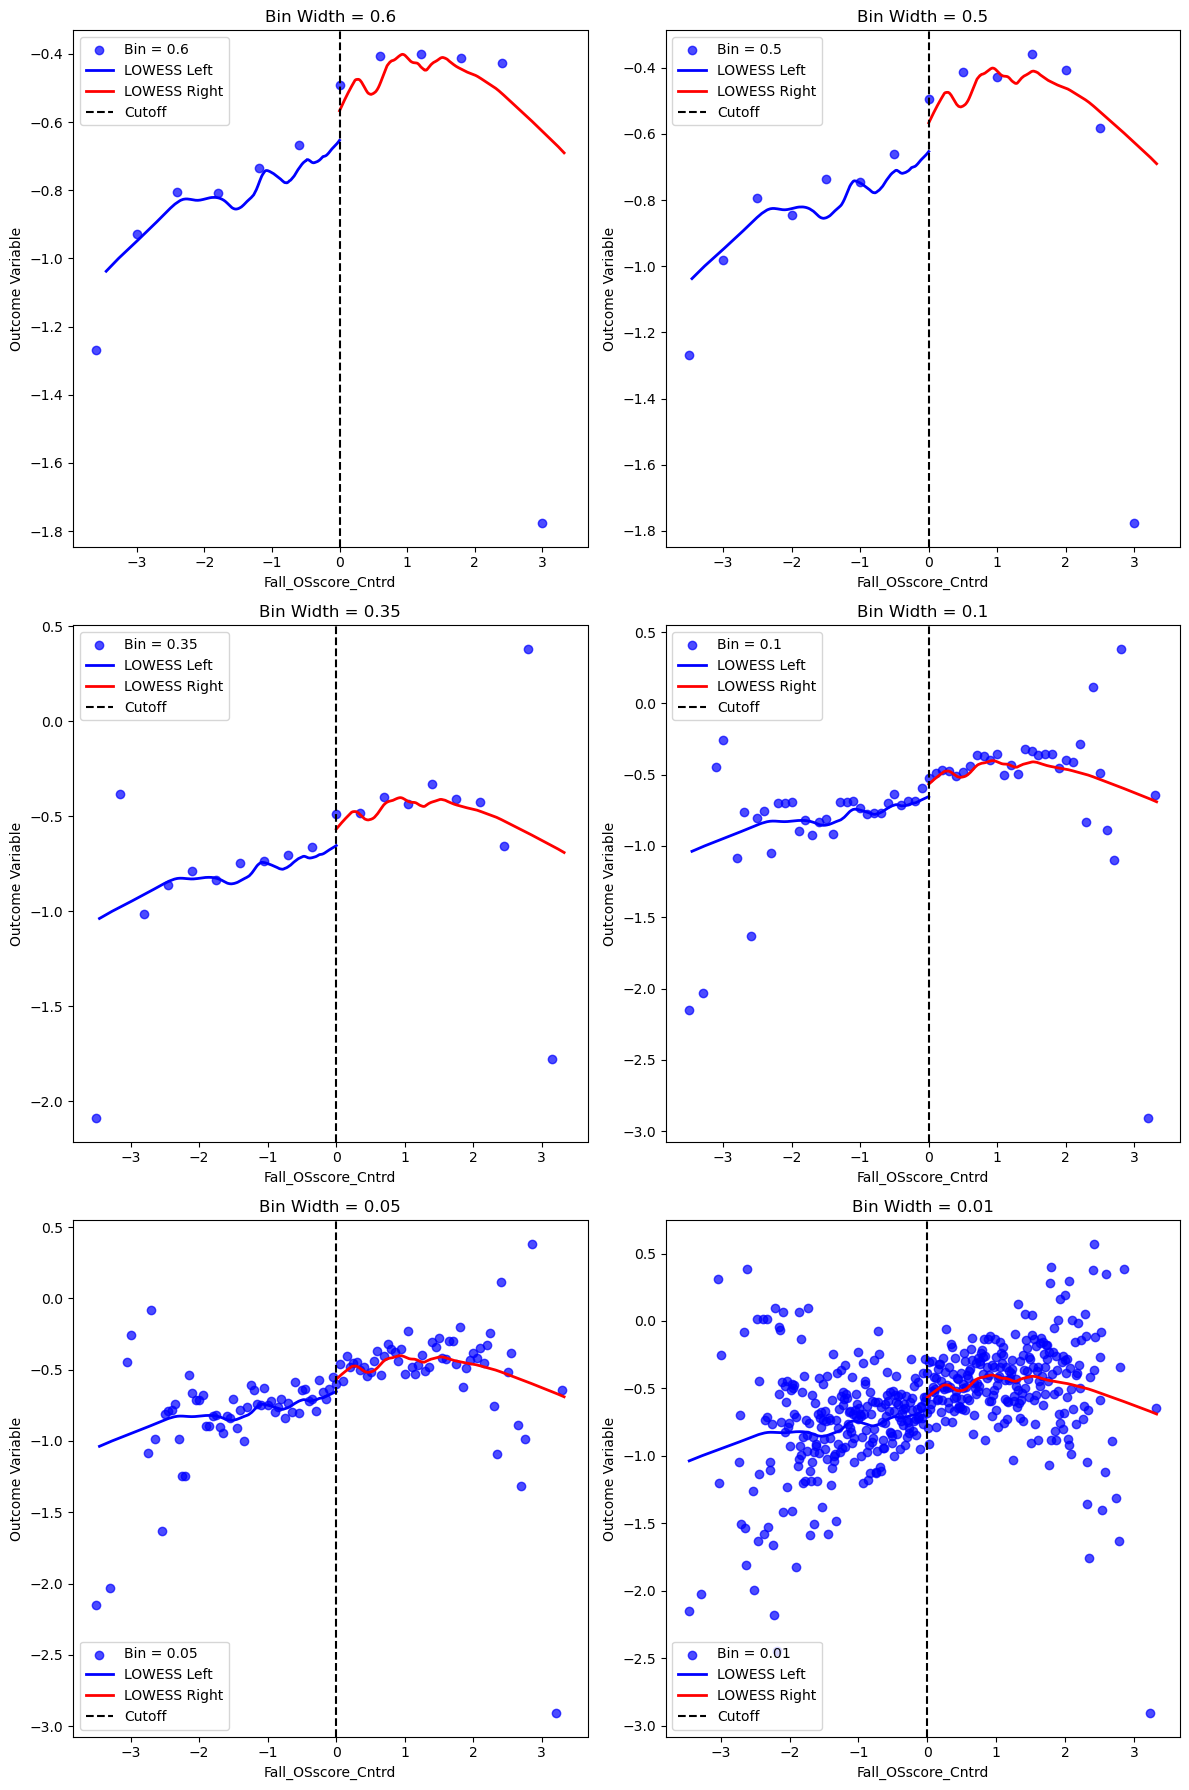

In [218]:
# Define bin widths and variables
bin_widths = [0.6, 0.5, 0.35, 0.1, 0.05, 0.01]
forcing_var = "Fall_OSscore_Cntrd"  # for Wave 1
outcome = "G3_zscore"  # 3rd grade outcome

# Set up the figure
plt.figure(figsize=(12, 18))

# Compute and plot for each bin width
for idx, bin_width in enumerate(bin_widths, start=1):
    # Add a subplot in the 3x2 grid
    plt.subplot(3, 2, idx)
    bin_means = calculate_bin_means(plot_df, outcome, forcing_var, bin_width)
    plot_bin_scatter_with_lowess_gap(plot_df, forcing_var, outcome, bin_means, bin_width, f"Bin = {bin_width}, Outcome = {outcome}")
    plt.title(f"Bin Width = {bin_width}")
# Adjust layout
plt.tight_layout()
plt.show()

#### For Wave 2 (midyear), for short-term outcomes aka 3rd Grade

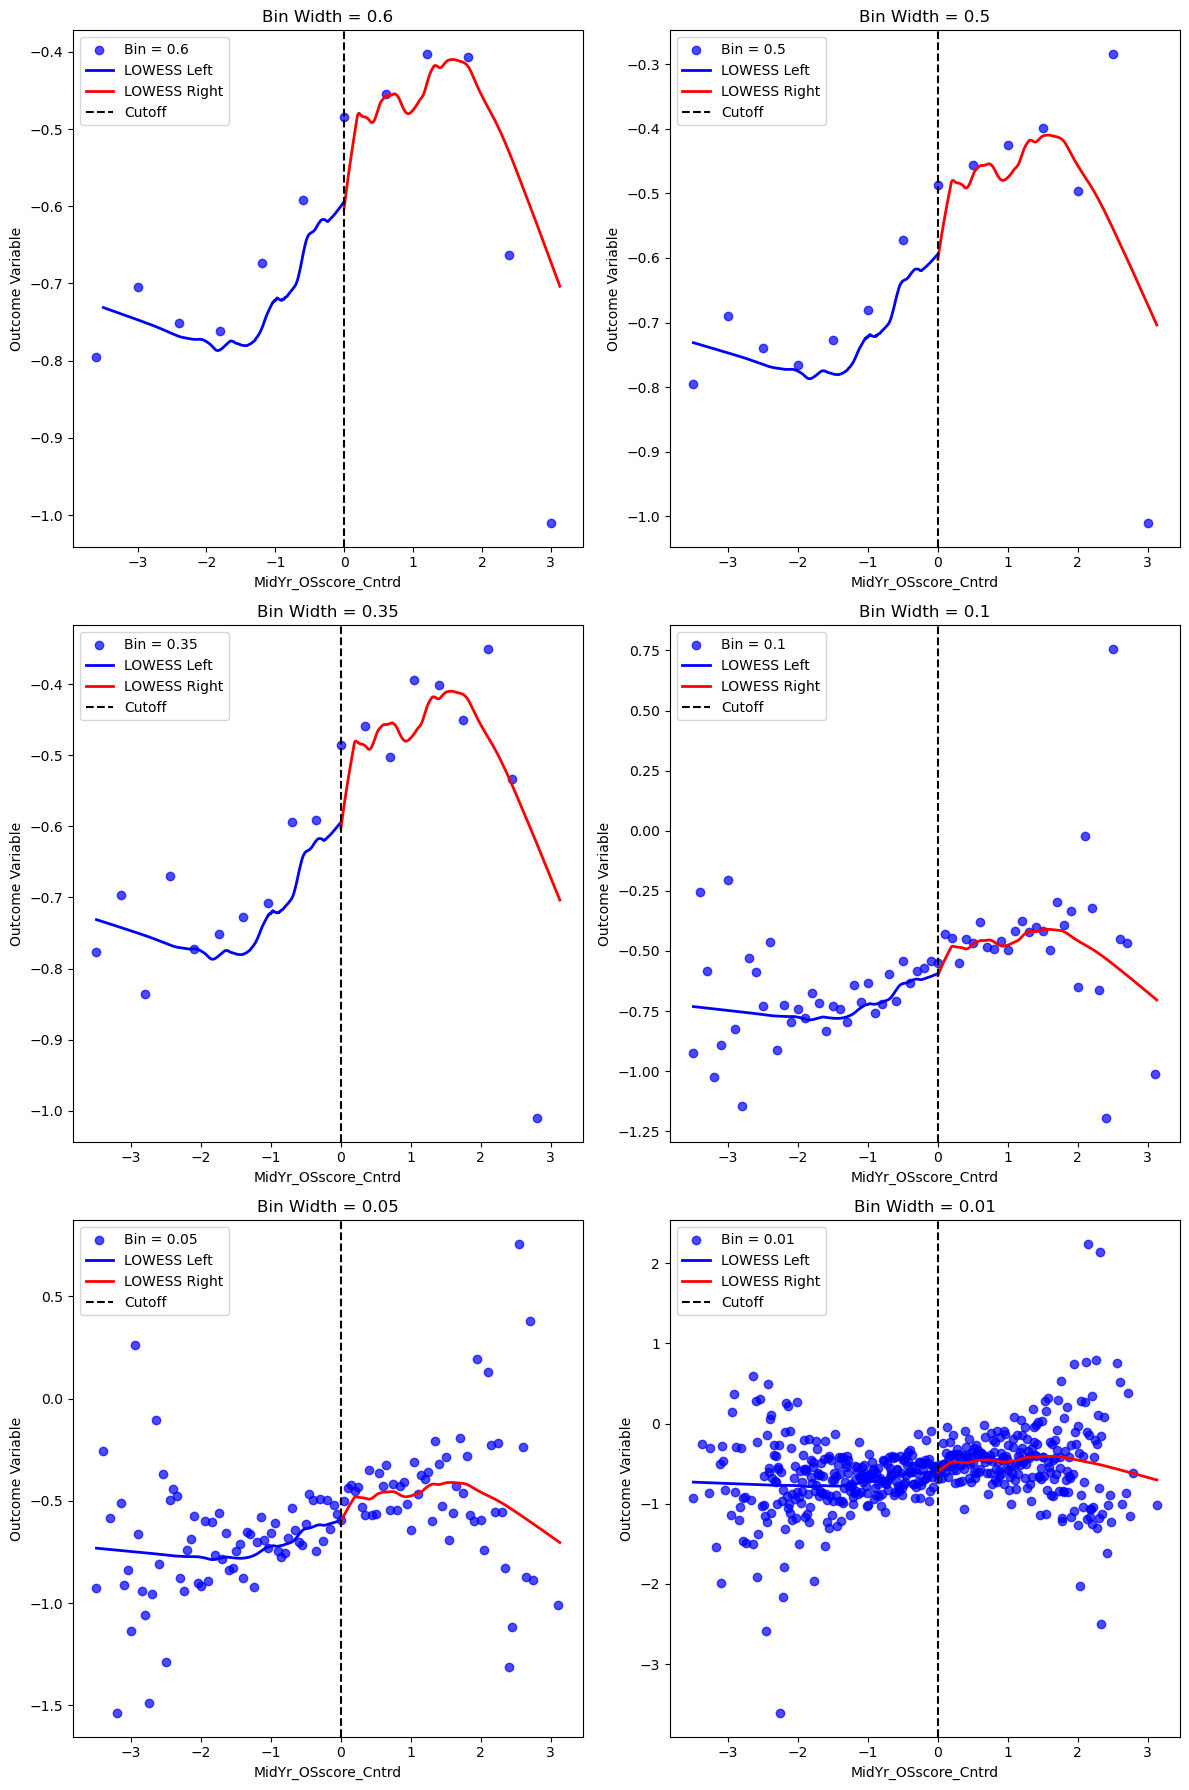

In [219]:
# Define bin widths and variables
bin_widths = [0.6, 0.5, 0.35, 0.1, 0.05, 0.01]
forcing_var = "MidYr_OSscore_Cntrd"  # for Wave 2
outcome = "G3_zscore"  # 3rd grade outcome

# Set up the figure
plt.figure(figsize=(12, 18))

# Compute and plot for each bin width
for idx, bin_width in enumerate(bin_widths, start=1):
    # Add a subplot in the 3x2 grid
    plt.subplot(3, 2, idx)
    bin_means = calculate_bin_means(plot_df, outcome, forcing_var, bin_width)
    plot_bin_scatter_with_lowess_gap(plot_df, forcing_var, outcome, bin_means, bin_width, f"Bin = {bin_width}, Outcome = {outcome}")
    plt.title(f"Bin Width = {bin_width}")
# Adjust layout
plt.tight_layout()
plt.show()

# Fraction 0.5 

In [68]:
def plot_bin_scatter_with_lowess_gap_5(df, forcing_var, outcome, bin_means, bin_width, title):
    """
    Plot the binned means along with separate LOWESS smoothing for left and right of the cutoff.
    """
    plt.figure(figsize=(8, 6))

    # Scatterplot of binned means
    plt.scatter(bin_means[f'bin_{bin_width}'], bin_means[outcome], label=f"Bin = {bin_width}", color="blue", alpha=0.7)

    # Split data at the cutoff
    left_data = df[df[forcing_var] < 0]
    right_data = df[df[forcing_var] > 0]

    # LOWESS smoothing for the left and right sides
    smoothed_left = lowess(left_data[outcome], left_data[forcing_var], frac=0.5)
    smoothed_right = lowess(right_data[outcome], right_data[forcing_var], frac=0.5)

    # Plot the LOWESS lines
    plt.plot(smoothed_left[:, 0], smoothed_left[:, 1], color="blue", linewidth=2, label="LOWESS Left")
    plt.plot(smoothed_right[:, 0], smoothed_right[:, 1], color="red", linewidth=2, label="LOWESS Right")

    # Formatting
    plt.axvline(x=0, color="black", linestyle="--", linewidth=1.5, label="Cutoff")
    plt.title(title)
    plt.xlabel("Forcing Variable")
    plt.ylabel("Outcome Variable")
    plt.legend()
    plt.show()

#### For Wave 1 (during fall), for short-term outcomes aka 3rd Grade

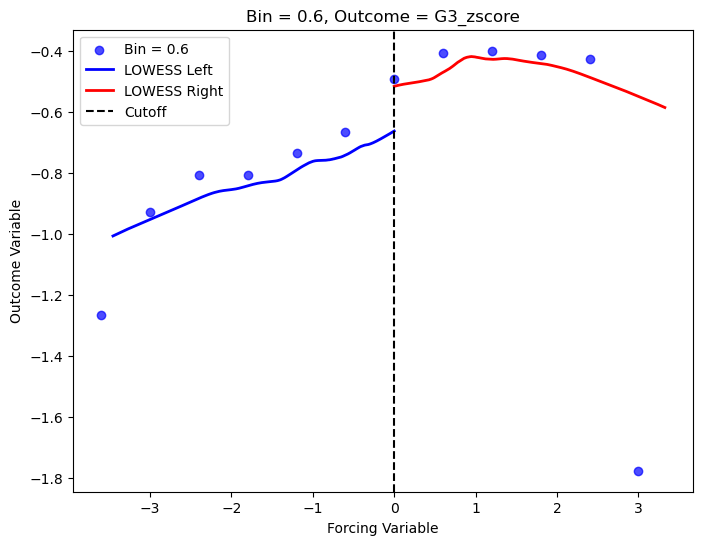

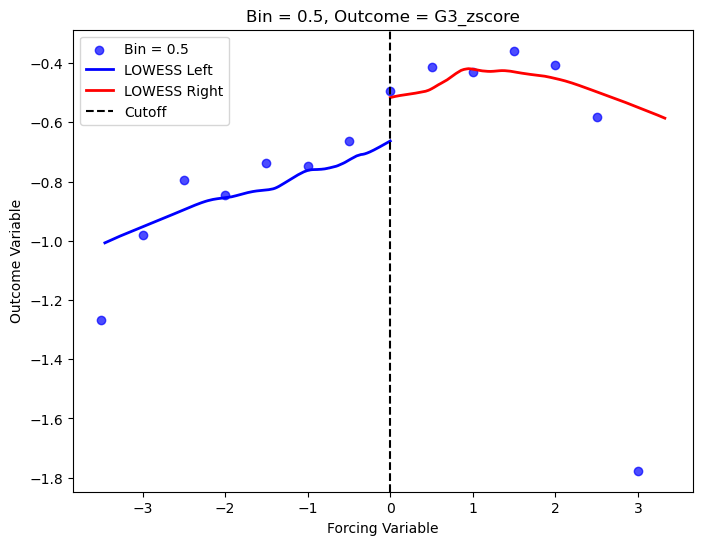

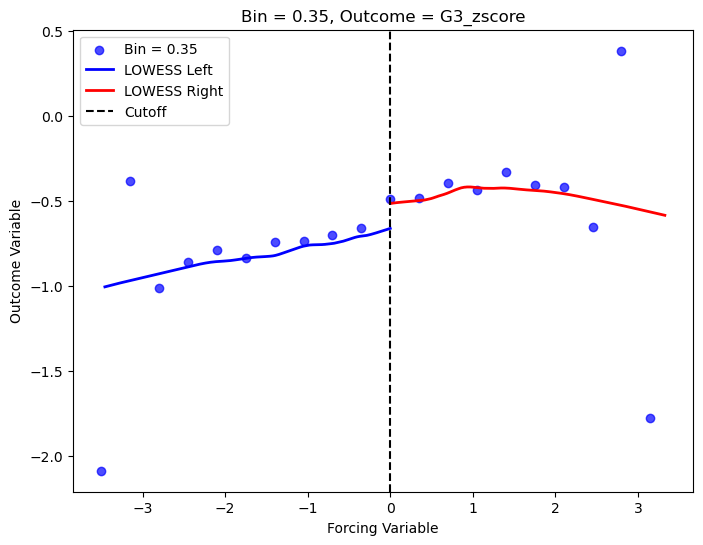

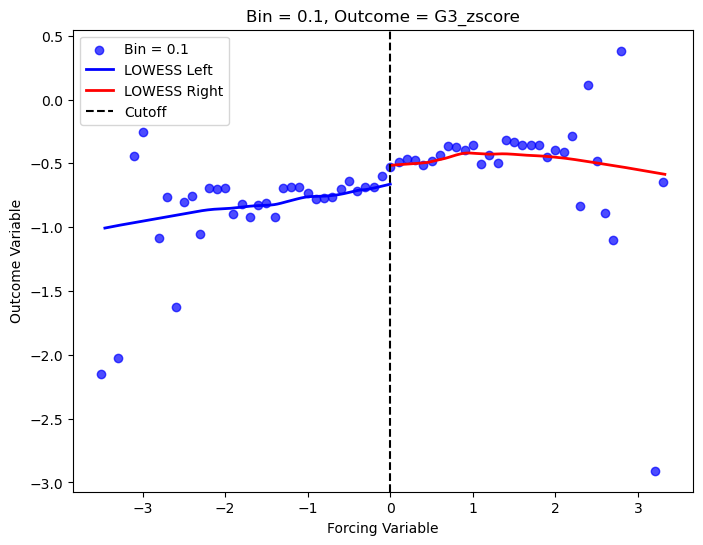

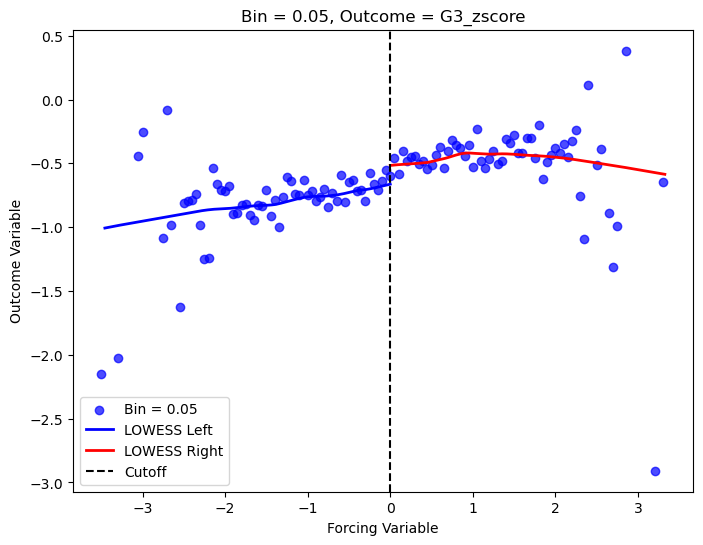

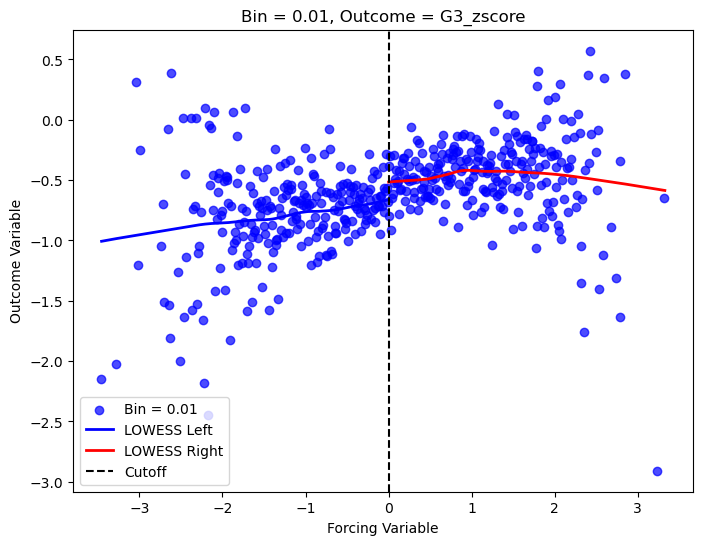

In [133]:
# Define bin widths and variables
bin_widths = [0.6, 0.5, 0.35, 0.1, 0.05, 0.01]
forcing_var = "Fall_OSscore_Cntrd"  # for Wave 1
outcome = "G3_zscore"  # 3rd grade outcome

# Compute and plot for each bin width
for bin_width in bin_widths:
    bin_means = calculate_bin_means(plot_df, outcome, forcing_var, bin_width)
    plot_bin_scatter_with_lowess_gap_5(plot_df, forcing_var, outcome, bin_means, bin_width, f"Bin = {bin_width}, Outcome = {outcome}")

#### For Wave 2 (midyear), for short-term outcomes aka 3rd Grade

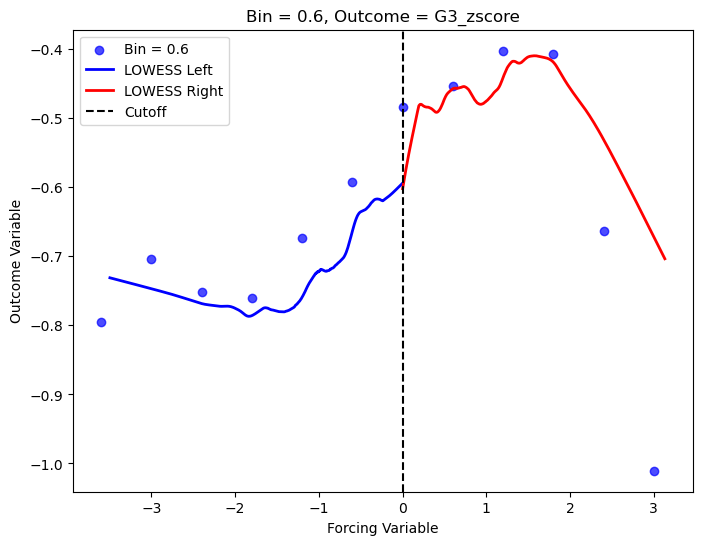

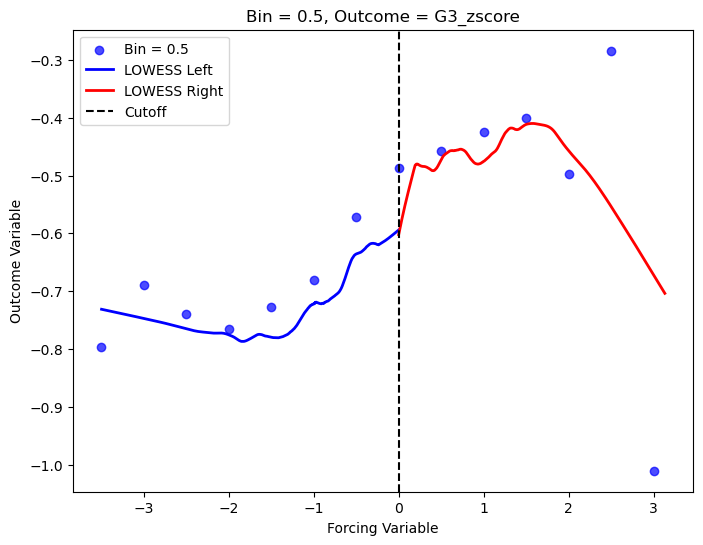

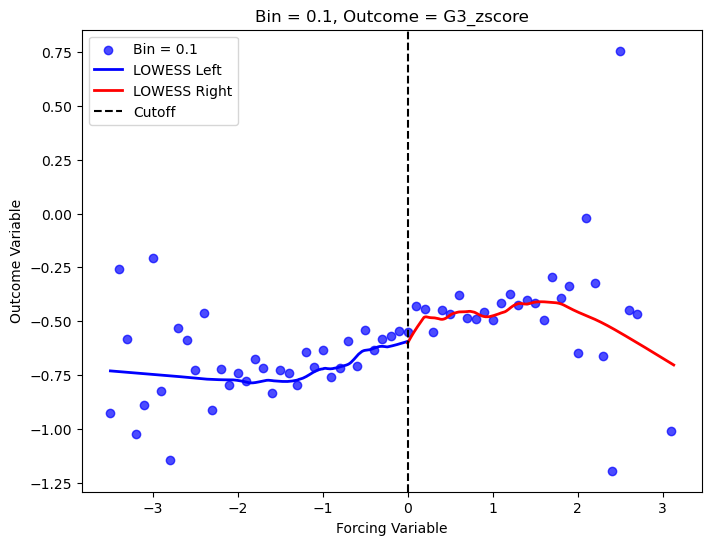

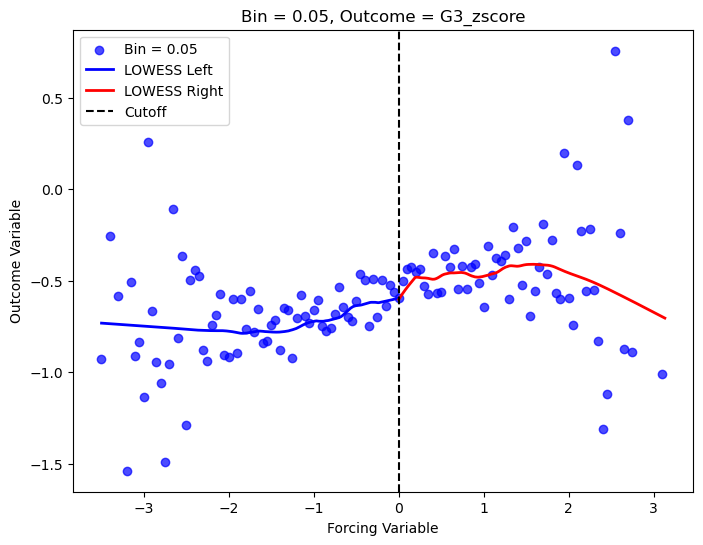

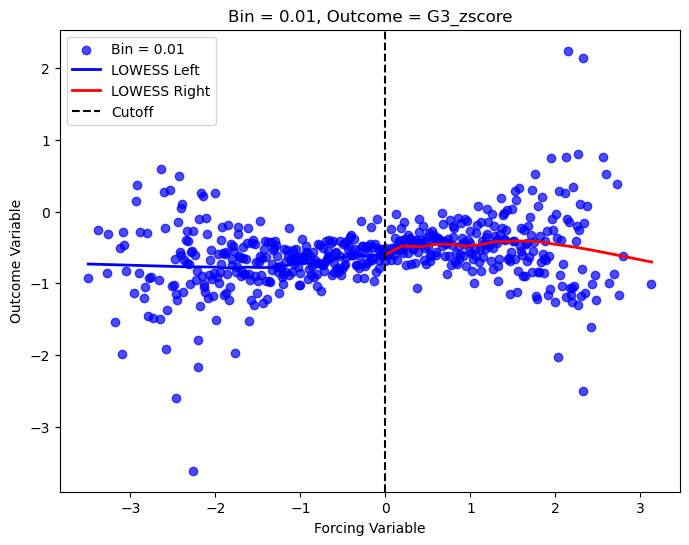

In [134]:
# Define bin widths and variables
bin_widths = [0.6, 0.5, 0.1, 0.05, 0.01]
forcing_var = "MidYr_OSscore_Cntrd"  # for Wave 2
outcome = "G3_zscore"  # 3rd grade outcome

# Compute and plot for each bin width
for bin_width in bin_widths:
    bin_means = calculate_bin_means(plot_df, outcome, forcing_var, bin_width)
    plot_bin_scatter_with_lowess_gap(plot_df, forcing_var, outcome, bin_means, bin_width, f"Bin = {bin_width}, Outcome = {outcome}")

# Frac interpretation
When we increased frac from 0.3 to 0.5, a larger fraction of the data was used in each local regression.
The result shows smoother curves, as the smoothing process considers more data points and is less sensitive to local variations.
#### Although with frac=0.5, the LOWESS lines appear more stable, this introduces bias as it reduces variance (and noise)

There is a clear trade-off between variability and trend visibility in our graphs. 
- If the bins are too narrow, there are too few observations in the bins, and the estimates will be very imprecise.
- If the bins are too wide, the estimates might be biased as they do not account for the slope in the regression line. They may include data far from the cutoff point, making it less clear if any effect we see is actually due to the policy change or other trends.

This optimal bandwidth h achieves a balance between precision (not too much noise) and bias (not oversmoothing).

In [87]:
def cross_validation_bandwidth(data, forcing_var, outcome_var, bandwidths, cutoff=0):
    """
    Perform cross-validation to select the optimal bandwidth for local regression.
    
    Parameters:
    - data: DataFrame containing the variables.
    - forcing_var: Name of the forcing variable (e.g., "Fall_OSscore_Cntrd").
    - outcome_var: Name of the outcome variable (e.g., "G3_zscore").
    - bandwidths: List of bandwidths to evaluate.
    - cutoff: The cutoff value for the forcing variable (default is 0).
    
    Returns:
    - optimal_bandwidth: The bandwidth that minimizes the cross-validation score (MSE).
    - mse_scores: A dictionary with bandwidths as keys and their corresponding MSE scores.
    """
    mse_scores = {}

    for h in bandwidths:
        predictions = []
        actuals = []
        
        # Loop through each observation for leave-one-out cross-validation
        for i in range(len(data)):
            # Exclude the current observation
            data_leave_one_out = data.drop(index=data.index[i])
            current_point = data.iloc[i]
            x_i = current_point[forcing_var]
            y_i = current_point[outcome_var]
            
            # Filter data based on the bandwidth and side of the cutoff
            if x_i < cutoff:
                subset = data_leave_one_out[
                    (data_leave_one_out[forcing_var] < cutoff) &
                    (data_leave_one_out[forcing_var] >= x_i - h)
                ]
            else:
                subset = data_leave_one_out[
                    (data_leave_one_out[forcing_var] > cutoff) &
                    (data_leave_one_out[forcing_var] <= x_i + h)
                ]
            
            # Skip if there's insufficient data in the subset
            if len(subset) < 2:
                continue
            
            # Calculate the local average as the prediction
            predicted_y = subset[outcome_var].mean()
            predictions.append(predicted_y)
            actuals.append(y_i)
        
        # Compute the MSE for this bandwidth
        mse = mean_squared_error(actuals, predictions)
        mse_scores[h] = mse

    # Find the optimal bandwidth (lowest MSE)
    optimal_bandwidth = min(mse_scores, key=mse_scores.get)
    
    return optimal_bandwidth, mse_scores

Optimal Bandwidth: 0.35
MSE Scores: {0.1: 0.7724536413291229, 0.15: 0.7717358921245242, 0.2: 0.7716478885403083, 0.25: 0.7713418921496448, 0.3: 0.7714096255367533, 0.35: 0.771325490286537, 0.4: 0.7714456462566107, 0.45: 0.7714759081226809, 0.5: 0.7713986262425635}


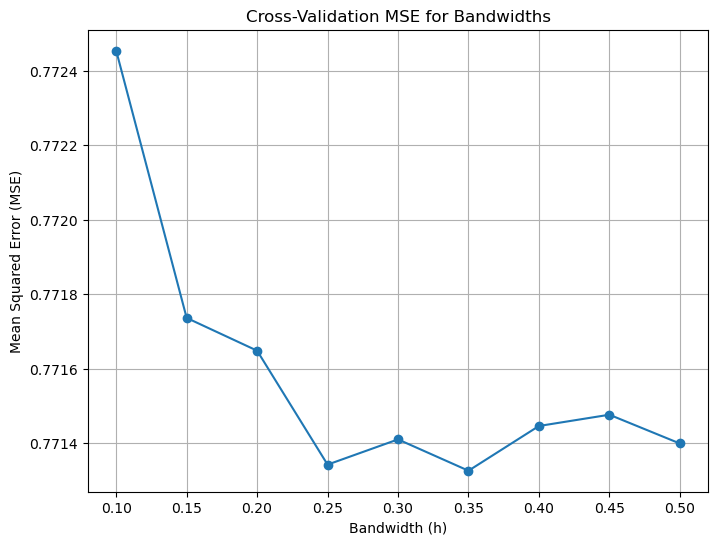

In [90]:
# Define relevant variables
forcing_var = "Fall_OSscore_Cntrd"  # Forcing variable for wave 1
outcome_var = "G3_zscore"  # Outcome variable for grade 3 scores
bandwidths = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]  # Bandwidths to evaluate
cutoff = 0  # Cutoff value for the forcing variable

# Step 1: Filter for Wave 1 data and drop NA
wave_1_data = plot_df[plot_df["GotRRfirst"] == 1]
wave_1_data = wave_1_data[[forcing_var, outcome_var]].dropna()

# Step 2: Perform cross-validation to select the optimal bandwidth
optimal_bandwidth, mse_scores = cross_validation_bandwidth(wave_1_data, forcing_var, outcome_var, bandwidths, cutoff)

# Step 3: Display results
print("Optimal Bandwidth:", optimal_bandwidth)
print("MSE Scores:", mse_scores)

# Plot the MSE scores for each bandwidth
plt.figure(figsize=(8, 6))
plt.plot(list(mse_scores.keys()), list(mse_scores.values()), marker='o', linestyle='-')
plt.title("Cross-Validation MSE for Bandwidths")
plt.xlabel("Bandwidth (h)")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()


Optimal Bandwidth: 0.35
MSE Scores: {0.1: 0.7114430102690049, 0.15: 0.7121829335294548, 0.2: 0.7122632818378654, 0.25: 0.7120721033960727, 0.3: 0.7113363756400014, 0.35: 0.7110798330535695, 0.4: 0.7111553219659255, 0.45: 0.7111010088115817, 0.5: 0.7114076427013208}


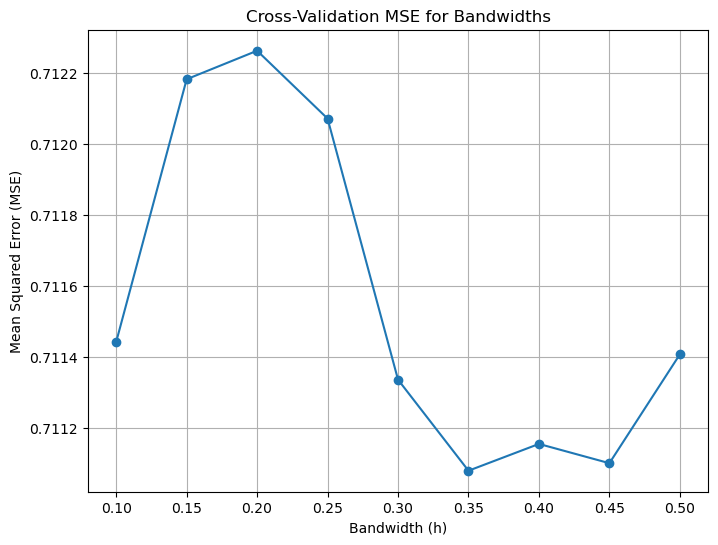

In [89]:
# Define relevant variables
forcing_var = "MidYr_OSscore_Cntrd"  # Forcing variable for wave 2
outcome_var = "G3_zscore"  # Outcome variable for grade 3 scores
bandwidths = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]  # Bandwidths to evaluate
cutoff = 0  # Cutoff value for the forcing variable

# Step 1: Filter for Wave 2 data and drop NA
wave_2_data = plot_df[plot_df["GotRRsecond"] == 1]
wave_2_data = wave_2_data[[forcing_var, outcome_var]].dropna()

# Step 2: Perform cross-validation to select the optimal bandwidth
optimal_bandwidth, mse_scores = cross_validation_bandwidth(wave_2_data, forcing_var, outcome_var, bandwidths, cutoff)

# Step 3: Display results
print("Optimal Bandwidth:", optimal_bandwidth)
print("MSE Scores:", mse_scores)

# Plot the MSE scores for each bandwidth
plt.figure(figsize=(8, 6))
plt.plot(list(mse_scores.keys()), list(mse_scores.values()), marker='o', linestyle='-')
plt.title("Cross-Validation MSE for Bandwidths")
plt.xlabel("Bandwidth (h)")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()

#### For both waves: Fall and midyear we get that the optimal bandwidth is 0.35

# Kernel Specification to confirm discontinuity
By applying different kernels, we want to test whether the observed jump or discontinuity at the cutoff persists regardless of how the weights are distributed around the cutoff.

By default, the LOWESS algorithm in statsmodels uses the tricube kernel for weighting observations. Tricube kernel had an MSE for fall of 0.771325490286537 and an MSE for Midyear of 0.7110798330535695.
Because this package does not offer the possibility to change the kernel, I will be using spicy to experiment with different kernel functions (Epanechnikov, Gaussian, Triangular, and Uniform)

Each kernel places different weights on the observations, influencing how the regression accounts for data near the cutoff:

- Epanechnikov: Prioritizes points closer to the cutoff, with weights smoothly decreasing to zero at the bandwidth's edge. It is optimal for many RDD contexts due to its balance of efficiency and simplicity.
- Gaussian: Assigns a continuous weight to all observations, with distant points receiving small but nonzero weights. This kernel is useful when smooth weighting across all observations is desired, but it can introduce bias in local estimation.
- Uniform: Gives equal weight to all observations within the bandwidth and zero weight to those outside. This kernel focuses equally on all nearby points but can produce less smooth fits.
- Triangular: Emphasizes points near the cutoff more strongly than Epanechnikov, with weights linearly decreasing to zero at the edges. It is useful for placing extra importance on closer observations.
- Tricube: Smoothly assigns very high weight to points close to the cutoff while giving zero weight to observations beyond the bandwidth. Its weighting function drops off more steeply than Epanechnikov and triangular, making it highly local and effective for focusing on the most relevant observations.

In [157]:
# Define kernels
def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return norm.pdf(u)

def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def triangular_kernel(u):
    return (1 - np.abs(u)) * (np.abs(u) <= 1)

# Kernel smoothing function
def kernel_smoothing(data, x_col, y_col, kernel, bandwidth, cutoff):
    x = data[x_col].values
    y = data[y_col].values

    smoothed_left = []
    smoothed_right = []
    x_left = x[x < cutoff]
    x_right = x[x > cutoff]

    # Smoothing for the left of the cutoff
    for xi in x_left:
        weights = kernel((xi - x_left) / bandwidth)
        smoothed_left.append(np.sum(weights * y[x < cutoff]) / np.sum(weights))

    # Smoothing for the right of the cutoff
    for xi in x_right:
        weights = kernel((xi - x_right) / bandwidth)
        smoothed_right.append(np.sum(weights * y[x > cutoff]) / np.sum(weights))

    return x_left, smoothed_left, x_right, smoothed_right

# Plot and calculate MSE for each kernel
def plot_with_kernels(data, forcing_var, outcome_var, bandwidth, cutoff):
    kernels = {
        "Epanechnikov": epanechnikov_kernel,
        "Gaussian": gaussian_kernel,
        "Uniform": uniform_kernel,
        "Triangular": triangular_kernel,  
    }

    plt.figure(figsize=(18, 6))
    mse_results = {}

    for i, (kernel_name, kernel_func) in enumerate(kernels.items()):
        x_left, smoothed_left, x_right, smoothed_right = kernel_smoothing(
            data, forcing_var, outcome_var, kernel_func, bandwidth, cutoff
        )

        mse_left = mean_squared_error(data[outcome_var][data[forcing_var] < cutoff], smoothed_left)
        mse_right = mean_squared_error(data[outcome_var][data[forcing_var] > cutoff], smoothed_right)
        mse_total = (mse_left + mse_right) / 2
        mse_results[kernel_name] = mse_total

        plt.subplot(1, 4, i + 1)
        plt.scatter(data[forcing_var], data[outcome_var], alpha=0.3, label="Data")
        plt.plot(x_left, smoothed_left, color="blue", label=f"Smoothed Left ({kernel_name})")
        plt.plot(x_right, smoothed_right, color="red", label=f"Smoothed Right ({kernel_name})")
        plt.axvline(cutoff, color="black", linestyle="--", label="Cutoff")
        plt.title(f"{kernel_name} Kernel")
        plt.xlabel(forcing_var)
        plt.ylabel(outcome_var)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Display MSE results
    for kernel_name, mse in mse_results.items():
        print(f"{kernel_name} Kernel MSE: {mse:.4f}")
    


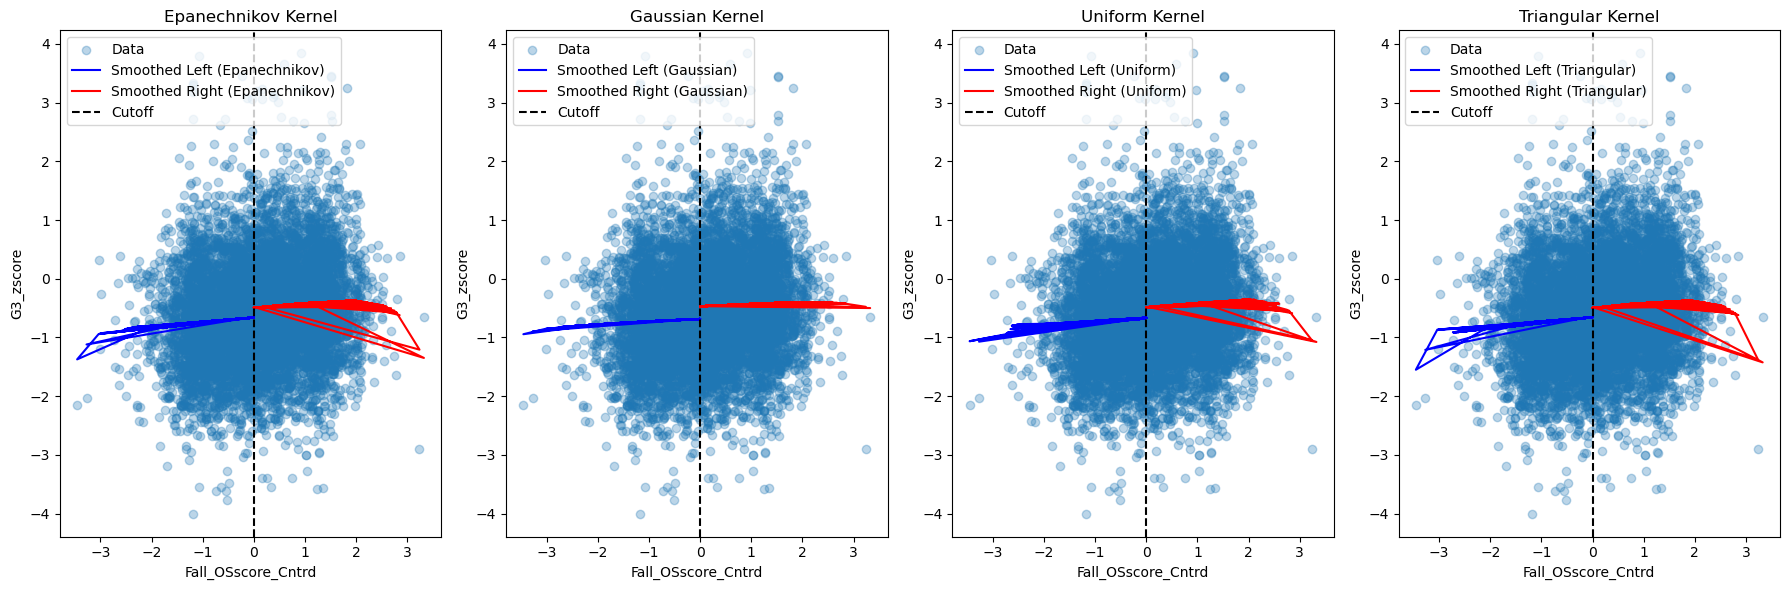

Epanechnikov Kernel MSE: 0.7719
Gaussian Kernel MSE: 0.7730
Uniform Kernel MSE: 0.7725
Triangular Kernel MSE: 0.7714


In [220]:
# Fall Example
forcing_var = "Fall_OSscore_Cntrd"
outcome_var = "G3_zscore"
data = plot_df[[forcing_var, outcome_var]].dropna()
plot_with_kernels(data, forcing_var, outcome_var, bandwidth=0.6, cutoff=0)

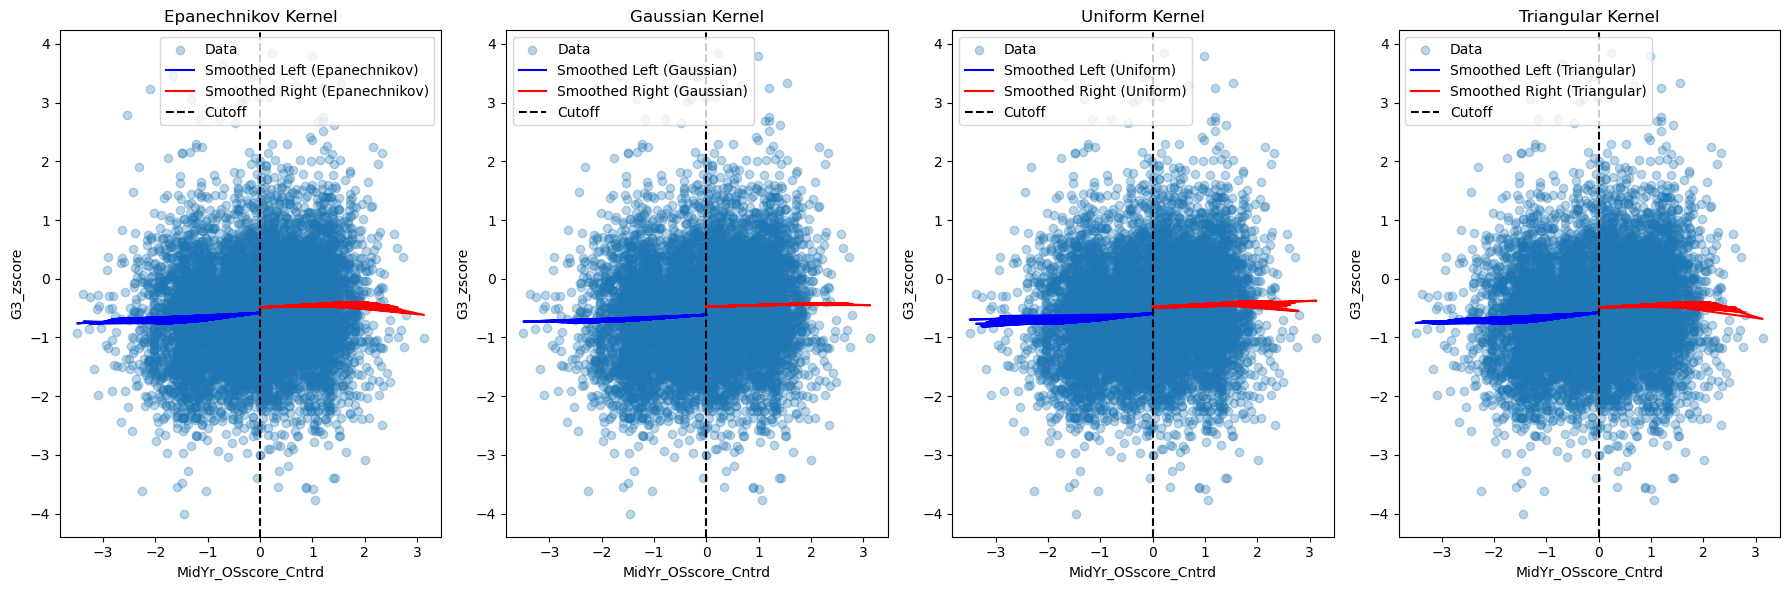

Epanechnikov Kernel MSE: 0.7790
Gaussian Kernel MSE: 0.7797
Uniform Kernel MSE: 0.7792
Triangular Kernel MSE: 0.7787


In [221]:
# MidYear Example
forcing_var = "MidYr_OSscore_Cntrd"
outcome_var = "G3_zscore"
data = plot_df[[forcing_var, outcome_var]].dropna()
plot_with_kernels(data, forcing_var, outcome_var, bandwidth=0.6, cutoff=0)

## For both fall and midyear, the lowest MSE is that of Tricube, followed by Triangular, Epanechnikov Kernel, then Uniform and finally Gaussian.

# Kernel Conclusion
Different kernels, as we see, lead to slightly different smoothed fits. But the treatment effect is similar in all of them, clearly distinguishable and not an artifact of oversmoothing, undersmoothing, or kernel choice.

# Graphical Presentation: Covariates and the Forcing Variable

#### We have no covariates unfortunately

In [138]:
# Define variables
forcing_var = "Fall_OSscore_Cntrd"
endogenous_var = "GotRRfirst"
instrument_var = "Fall_BelowCut"

# Prepare data
first_stage_data = plot_df[[forcing_var, endogenous_var, instrument_var]].dropna()

# First stage: Regress GotRRfirst on Fall_BelowCut and Fall_OSscore_Cntrd
X_first_stage = first_stage_data[[instrument_var, forcing_var]]  # Instrument + Exogenous variable
X_first_stage = sm.add_constant(X_first_stage)  # Add constant for intercept
y_first_stage = first_stage_data[endogenous_var]

# Fit the OLS model
first_stage_model = sm.OLS(y_first_stage, X_first_stage).fit()

# Display results
print(first_stage_model.summary())


                            OLS Regression Results                            
Dep. Variable:             GotRRfirst   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 5.360e+04
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:50:23   Log-Likelihood:                 1339.6
No. Observations:               29530   AIC:                            -2673.
Df Residuals:                   29527   BIC:                            -2648.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1105      0

- The coefficient of Fall_BelowCut (0.7742) is strong and highly significant, confirming that it is a relevant instrument.
The very high F-statistic (5.360e+04) further indicates that the instrument is not weak.
- The high R-squared value suggests that the predictors explain most of the variability in GotRRfirst.
- The purpose of this first stage is to ensure that the instrument (Fall_BelowCut) is strongly correlated with the endogenous variable (GotRRfirst). The results confirm this.

In [139]:
# Define variables
forcing_var = "Fall_OSscore_Cntrd"
outcome_var = "G3_zscore"
treatment_var = "GotRRfirst"
instrument_var = "Fall_BelowCut"

# Step 1: Prepare the data
wave_1_data = plot_df[[forcing_var, outcome_var, treatment_var, instrument_var]].dropna()

# Step 2: Specify the 2SLS Model
# First Stage: GotRRfirst ~ Fall_BelowCut + Fall_OSscore_Cntrd
# Second Stage: G3_zscore ~ GotRRfirst_hat + Fall_OSscore_Cntrd

formula = f"{outcome_var} ~ 1 + [{treatment_var} ~ {instrument_var}] + {forcing_var}"
iv_model = IV2SLS.from_formula(formula, data=wave_1_data)
iv_result = iv_model.fit()

# Step 3: Display the Results
print(iv_result.summary)


                          IV-2SLS Estimation Summary                          
Dep. Variable:              G3_zscore   R-squared:                      0.0288
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0286
No. Observations:                8025   F-statistic:                    219.98
Date:                Thu, Jan 23 2025   P-value (F-stat)                0.0000
Time:                        19:51:32   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.4862     0.0240    -20.296     0.0000     -0.5332     -0.4393
Fall_OSscore_Cntrd  

- Intercept: -0.4862: Represents the baseline level of G3_zscore when Fall_OSscore_Cntrd and GotRRfirst are zero.
- Fall_OSscore_Cntrd: 0.0665: For every one-unit increase in Fall_OSscore_Cntrd, G3_zscore increases by 0.07, holding the treatment and other variables constant. This is statistically significant (p-value = 0.0008).
- GotRRfirst: -0.1949: Receiving GotRRfirst is associated with a reduction of 0.1949 in G3_zscore. This effect is statistically significant (p-value = 0.0000), and the negative sign suggests a potential adverse effect.

#### The negative coefficient suggests that receiving GotRRfirst is associated with a reduction in G3_zscore. This seems counterintuitive but aligns with the results of the paper we are replicating.

In [141]:
# Define variables
forcing_var = "MidYr_OSscore_Cntrd"
endogenous_var = "GotRRsecond"
instrument_var = "MidYr_BelowCut"

# Prepare data
first_stage_data = plot_df[[forcing_var, endogenous_var, instrument_var]].dropna()

# First stage: Regress GotRRfirst on Fall_BelowCut and Fall_OSscore_Cntrd
X_first_stage = first_stage_data[[instrument_var, forcing_var]]  # Instrument + Exogenous variable
X_first_stage = sm.add_constant(X_first_stage)  # Add constant for intercept
y_first_stage = first_stage_data[endogenous_var]

# Fit the OLS model
first_stage_model = sm.OLS(y_first_stage, X_first_stage).fit()

# Display results
print(first_stage_model.summary())


                            OLS Regression Results                            
Dep. Variable:            GotRRsecond   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     6381.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:54:09   Log-Likelihood:                -11951.
No. Observations:               29530   AIC:                         2.391e+04
Df Residuals:                   29527   BIC:                         2.393e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0086    

- The coefficient of MidYr_BelowCut (0.5416) is strong and highly significant, confirming that it is a relevant instrument.
The very high F-statistic (6381) further indicates that the instrument is not weak.
- The R-squared value suggests that the predictors explain 30% of the variability in GotRRsecond.
- The instrument (MidYr_BelowCut) is strongly correlated with the endogenous variable (GotRRsecond). 

In [142]:
# Define variables
forcing_var = "MidYr_OSscore_Cntrd"
outcome_var = "G3_zscore"
treatment_var = "GotRRsecond"
instrument_var = "MidYr_BelowCut"

# Step 1: Prepare the data
wave_2_data = plot_df[[forcing_var, outcome_var, treatment_var, instrument_var]].dropna()

# Step 2: Specify the 2SLS Model
# First Stage: GotRRfirst ~ Fall_BelowCut + Fall_OSscore_Cntrd
# Second Stage: G3_zscore ~ GotRRfirst_hat + Fall_OSscore_Cntrd

formula = f"{outcome_var} ~ 1 + [{treatment_var} ~ {instrument_var}] + {forcing_var}"
iv_model = IV2SLS.from_formula(formula, data=wave_2_data)
iv_result = iv_model.fit()

# Step 3: Display the Results
print(iv_result.summary)


                          IV-2SLS Estimation Summary                          
Dep. Variable:              G3_zscore   R-squared:                      0.0053
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0051
No. Observations:                8025   F-statistic:                    135.57
Date:                Thu, Jan 23 2025   P-value (F-stat)                0.0000
Time:                        19:54:24   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
Intercept              -0.5178     0.0194    -26.672     0.0000     -0.5559     -0.4798
MidYr_OSscore_Cn

- Intercept: -0.5178 : Represents the baseline level of G3_zscore when MidYr_OSscore_Cntrd and GotRRsecond are zero.
- MidYr_OSscore_Cntrd: 0.0846: For every one-unit increase in MidYr_OSscore_Cntrd, G3_zscore increases by 0.0846, holding the treatment and other variables constant. This is statistically significant (p-value = 0.0000).
- GotRRsecond: -0.1501: Receiving GotRRsecond is associated with a reduction of 0.1501 in G3_zscore. This effect is statistically significant at 2.5% and 5% but not at 1% levels (p-value = 0.00223), and the negative sign suggests a potential adverse effect.

#### The negative coefficient suggests that receiving GotRRsecond is associated with a reduction in G3_zscore. This seems counterintuitive but aligns with the results of the paper we are replicating.